# Check to see if we're running in Colab (versus local server)

In [ ]:
try:
    from google.colab import drive

    IN_COLAB = True
except ModuleNotFoundError:
    IN_COLAB = False

if IN_COLAB:
    print("We're running Colab")

We're running Colab


# Mount the Google Drive (if we're in Colab), switch current directory to a directory on the Google Drive
- we will (optionally) create the specified directory on the Google Drive if it doesn't exist

- navigate to our Harvard Capstone shared folder -> right-click -> organize -> add shortcut -> all locations -> add "My Drive"

In [ ]:
if IN_COLAB:
    # Mount the Google Drive at mount
    mount = "/content/gdrive"
    print("Colab: mounting Google drive on ", mount)

    drive.mount(mount)

    # Switch to the directory on the Google Drive that you want to use
    import os

    drive_root = mount + "/My Drive/Harvard Capstone/Modeling/UNet"

    # Create drive_root if it doesn't exist
    # create_drive_root = True
    # if create_drive_root:
    #  print("\nColab: making sure ", drive_root, " exists.")
    #  os.makedirs(drive_root, exist_ok=True)

    # Change to the directory
    print("\nColab: Changing directory to ", drive_root)
    %cd $drive_root

Colab: mounting Google drive on  /content/gdrive
Mounted at /content/gdrive

Colab: Changing directory to  /content/gdrive/My Drive/Harvard Capstone/Modeling/UNet
/content/gdrive/.shortcut-targets-by-id/1eW3hLH0IEClxPvf9Y2NP-NAtoaEftFcx/UNet


In [ ]:
# Verify we're in the correct working directory
%pwd

'/content/gdrive/.shortcut-targets-by-id/1eW3hLH0IEClxPvf9Y2NP-NAtoaEftFcx/UNet'

In [ ]:
def delete_all_empty_checkpoint_folders(
    checkpoint_path: str = "./model_checkpoints/jbacon/",
):
    """Checkpoint folders get created quite often but don't always end up with anything being written to them"""
    # Delete all empty checkpoint folders
    folders = list(os.walk(checkpoint_path))[1:]

    for folder in folders:
        if not folder[1] and not folder[2]:
            print(folder)
            os.rmdir(folder[0])
        elif not folder[1] and folder[2] == ["model_params.json"]:
            print(folder)
            os.remove(os.path.join(folder[0], folder[2][0]))
            os.rmdir(folder[0])


if IN_COLAB:
    delete_all_empty_checkpoint_folders("./model_checkpoints/jbacon/")

KeyboardInterrupt: 

# Work with files on the Google Drive
- existing files
- upload files to Google Drive (as per normal)
- load files from external source

## Verify that imports (of modules on the Google Drive) work

In [ ]:
import glob, json, os
import datetime as dt
import datetime
from IPython.display import HTML
import tqdm

import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from scipy import ndimage
from scipy.ndimage import sobel, binary_erosion, label
import skimage
from numba import jit

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    Dropout,
    Conv2DTranspose,
    concatenate,
    Input,
    Lambda,
    Activation,
    Layer,
    Add,
    Reshape,
)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    UpSampling2D,
    concatenate,
    Conv2DTranspose,
    Dense,
    Flatten,
    Reshape,
)

# Set configuration constants

In [ ]:
data_root = "masked_ims_netcdf_1km_cropped_2_000km_window_74lat_-170lon"
if not IN_COLAB:
    data_root = os.path.join("..", "data", data_root)
    tf.config.set_visible_devices([], "GPU")
WINDOW_SIZE = 2000  # km

In [ ]:
batch_size = 1
test_batch_size = 1
dim = (WINDOW_SIZE, WINDOW_SIZE, 3)

## Data Processing: XArray and Numpy


In [ ]:
# Define a function to load a single .nc file for a given year and day
def load_nc_file(year, day) -> xr.Dataset:
    """Loads the cropped, grid-corrected netcdf files on the Beaufort Sea with 74,0lat_-170,0lon"""
    # Generate the file path based on the year and day
    file_path = os.path.join(
        data_root,
        str(year),
        f"ims{year}{day:03d}_1km_v1.3_grid{WINDOW_SIZE}_74,0lat_-170,0lon.nc",
    )

    # Load the .nc file using xarray
    with xr.open_dataset(file_path) as dataset:
        return dataset

In [ ]:
def load_sie_data(year, day) -> np.array:
    """Returns a 2D numpy array copy of the IMS surface values"""
    data = load_nc_file(year, day).IMS_Surface_Values[0].values.copy()
    data[np.isnan(data)] = 0
    return data

In [ ]:
def load_binary_sie_data(year, day) -> np.array:
    """Returns a 2D numpy array copy of the IMS surface values"""
    sie = load_sie_data(year, day)
    binary_sie = sie.copy()
    # Send land to the open water class so we have 0 (not sea ice) and 1 (sea ice).
    binary_sie[sie == 2] = 0

    return binary_sie

In [ ]:
# def trinarize_data(sie: np.array) -> np.array:
#     """
#     New SIE:
#     0: Open water/out of bounds
#     1: Sea ice or lake ice (lake mask not applied)
#     2: Land
#     """
#     trinary_sie = sie.copy()
#     trinary_sie[sie != 3] = 0

#     # Sea and Lake Ice is treated as 1
#     trinary_sie[sie == 3] = 1

#     # Land and Snow-Covered Land is sent to 2.
#     trinary_sie[sie == 2] = 2
#     trinary_sie[sie == 4] = 2
#     return trinary_sie

In [ ]:
def load_n_day_chunk(year: int, day: int, n=4) -> np.array:
    """
    Return np.array with shape (height, width, channels).

    Does NOT wrap years or account for missing days.
    Starts n_day chunk at specified day, year.

    Returns:
        np.array: shape (sie_y_shape, sie_x_shape, n_day)
    """
    sie_chunk = []
    for new_day in range(day, day + n):
        sie = load_sie_data(year, new_day)
        sie_chunk.append(sie)

    assert len(sie_chunk) == n
    # Use np.stack to stack the individual 2D arrays along a new third axis, resulting in (height, width, channels)
    return np.stack(sie_chunk, axis=-1)

## Loading and Visualizing Data: Example usage

Demonstrates how to load SIE from file, how the load_n_day_chunk function works, and how the arrays are ordered.

In [ ]:
example = True
if example:
    year = 2022
    day = 200
    n = 4

    data = load_nc_file(year, day)
    multiclass_sie = load_sie_data(year, day)
    sie = multiclass_sie
    last_sie = load_sie_data(year, day + n - 1)
    sie_chunk = load_n_day_chunk(
        year, day, n
    )  # Chunk will not include day+n, only up to day+n-1.

    # Earliest day is first, latest SIE extent is last in the chunk
    plt.title(f"Earliest SIE in loaded SIE chunk {year} {day}")
    plt.imshow(sie_chunk[:, :, 0])
    plt.show()

    # The first SIE in the chunk array is the earliest date.
    assert np.allclose(sie_chunk[:, :, 0], sie)

    # Earliest day is first, latest SIE extent is last in the chunk
    plt.title(f"Latest SIE in loaded SIE chunk {year} {day+n-1}")
    plt.imshow(sie_chunk[:, :, -1])
    plt.show()

    # The last SIE in the chunk array is the last date.
    assert np.allclose(sie_chunk[:, :, -1], last_sie)

# Data Processing: Loading data for Tensorflow

## Data generator for all data available
To be used as either train or test data generator, depending on slice of filenames passed in.

In [ ]:
class BinaryTargetGenerator(tf.keras.utils.Sequence):
    """
    Generator for Keras training to allow multiprocessing and training on batches with only the
    batch itself being loaded into memory.

    """

    def __init__(
        self,
        filenames: list[str],
        batch_size: int = 2,
        dim: tuple = (8000, 8000, 5),
    ):
        self.batch_size = batch_size
        self.dim = dim  # (height, width, channel)

        self.filenames = sorted(filenames)
        self.years = self.years_from_filenames()
        self.days = self.days_from_filenames()

        # Dictionary to look up where the year day (2022, 151) is in self.years and self.days
        self.index_of_year_day = {
            year_day: index for index, year_day in enumerate(zip(self.years, self.days))
        }

        self.data_IDs = self._get_data_ids(
            self.years[: -self.dim[2]], self.days[: -self.dim[2]]
        )

    def years_from_filenames(self) -> list[int]:
        years = [
            int(file.split("/")[-1].split("ims")[1][:4]) for file in self.filenames
        ]
        return years

    def days_from_filenames(self) -> list[int]:
        days = [int(file.split("/")[-1].split("_")[0][-3:]) for file in self.filenames]
        return days

    def _get_data_ids(self, years: list[int], days: list[int]) -> list[tuple]:
        return list(zip(years, days))

    def get_years_days_of_batch(self, index: int) -> list[tuple]:
        """Given a batch index, return a list of the year and days for that batch"""
        years = self.years[index * self.batch_size : (index + 1) * self.batch_size]
        days = self.days[index * self.batch_size : (index + 1) * self.batch_size]
        return list(zip(years, days))

    def __len__(self):
        """Number of batches per epoch"""
        return len(self.data_IDs) // self.batch_size

    def __getitem__(self, index: int) -> tuple[np.array, np.array]:
        """Generate one batch of data"""
        # Collect data IDs for this batch number
        batch_data_ids = self.data_IDs[
            index * self.batch_size : (index + 1) * self.batch_size
        ]

        # Generate data
        X, y = self._data_generation(batch_data_ids)

        return X.astype("float16"), y.astype("float16")

    def load_n_day_chunk(self, year: int, day: int, n: int) -> np.array:
        """Starts at year, day and returns the next n days of processed SIE."""
        i = self.index_of_year_day[(year, day)]
        days = self.days[i : i + n]
        years = self.years[i : i + n]

        sie_chunk = []
        for year, day in zip(years, days):
            sie = load_sie_data(year, day)
            sie_chunk.append(sie)

        assert len(sie_chunk) == n
        # Use np.stack to stack the individual 2D arrays along a new third axis, resulting in (height, width, channels)
        return np.stack(sie_chunk, axis=-1)

    def load_binary_y_for_day(self, year: int, day: int, n: int) -> np.array:
        """If the initial X data day is 10 with offset 3, load day 13, binarize it, and return the shape expected of y data"""
        i = self.index_of_year_day[(year, day)]
        y_data = np.expand_dims(
            load_binary_sie_data(
                self.years[i + self.dim[2]], self.days[i + self.dim[2]]
            ),
            axis=-1,
        )
        return y_data

    def _data_generation(self, batch_data_ids):
        """Generates data containing batch_size samples"""
        X = np.empty((self.batch_size, *self.dim), dtype="float16")
        y = np.empty((self.batch_size, self.dim[0], self.dim[1], 1), dtype="float16")

        for i, (year, day) in enumerate(batch_data_ids):
            # Load a n-day chunk as the input
            X[i] = self.load_n_day_chunk(year, day, self.dim[2])

            # Load the next day as the target
            y[i] = self.load_binary_y_for_day(year, day, self.dim[2])

        return X, y

# Test/Train split

In [ ]:
test_frac = 0.2
validation_frac = 0.1

train_frac = 1 - validation_frac - test_frac
all_netcdf_files = sorted(
    glob.glob(os.path.join(data_root, "**", "*.nc"), recursive=True)
)

train_idx = int(len(all_netcdf_files) * train_frac)
test_idx = train_idx + int(len(all_netcdf_files) * test_frac)

train_files = all_netcdf_files[:train_idx]
test_files = all_netcdf_files[train_idx:test_idx]
validation_files = all_netcdf_files[test_idx:]

print("Number of Train files is: ", len(train_files))
print("Number of Test files is: ", len(test_files))
print("Number of Validation files is: ", len(validation_files))

In [ ]:
len(all_netcdf_files)

### Model prototype
Very simple UNet model that takes the entire region of interest in and outputs an image of the same size.

In [ ]:
def simple_unet_with_sigmoid(input_shape=(4000 * 2, 4000 * 2, 5)):
    inputs = Input(input_shape)

    # Downsample
    c1 = Conv2D(16, (3, 3), activation="relu", padding="same")(inputs)
    p1 = MaxPooling2D((2, 2))(c1)
    c2 = Conv2D(32, (3, 3), activation="relu", padding="same")(p1)
    p2 = MaxPooling2D((2, 2))(c2)

    # Bottleneck
    b = Conv2D(64, (3, 3), activation="relu", padding="same")(p2)

    # Upsample
    u1 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding="same")(b)
    u1 = concatenate([u1, c2])
    u2 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding="same")(u1)
    u2 = concatenate([u2, c1])
    outputs = Conv2D(1, (1, 1), activation="sigmoid")(u2)  # between 0 and 1
    model = Model(inputs=[inputs], outputs=[outputs])

    return model


def simple_unet_with_skip(input_shape: tuple[int, int, int]):
    """
    Unet to predict the change in sea ice concentration by adding last day's forecast
    to model output, then sigmoid activation for pixel-wise classification.
    """
    inputs = Input(input_shape)
    # Slice the last channel of the input
    last_channel = Lambda(lambda x: x[:, :, :, -1:])(
        inputs
    )  # Assuming the last channel is what we want to add to the output

    # Downsample
    c1 = Conv2D(16, (3, 3), activation="relu", padding="same")(inputs)
    p1 = MaxPooling2D((2, 2))(c1)
    c2 = Conv2D(32, (3, 3), activation="relu", padding="same")(p1)
    p2 = MaxPooling2D((2, 2))(c2)

    # Bottleneck
    b = Conv2D(64, (3, 3), activation="relu", padding="same")(p2)

    # Upsample
    u1 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding="same")(b)
    u1 = concatenate([u1, c2])
    u2 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding="same")(u1)
    u2 = concatenate([u2, c1])

    # Concatenate the last channel of the input with the last upsampled features before the final convolution
    pre_output = concatenate([u2, last_channel], axis=-1)

    # Final convolution without activation
    outputs = Conv2D(1, (1, 1), padding="same", activation="sigmoid")(pre_output)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model


def extended_unet_with_sie(input_shape=(2000, 2000, 4)):
    inputs = Input(input_shape)

    # Downsample
    c1 = Conv2D(16, (3, 3), activation="relu", padding="same")(inputs)
    p1 = MaxPooling2D((2, 2))(c1)
    c2 = Conv2D(32, (3, 3), activation="relu", padding="same")(p1)
    p2 = MaxPooling2D((2, 2))(c2)
    c3 = Conv2D(64, (3, 3), activation="relu", padding="same")(p2)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bottleneck
    b = Conv2D(128, (3, 3), activation="relu", padding="same")(p3)

    # Upsample
    u1 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(b)
    u1 = concatenate([u1, c3])
    u2 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding="same")(u1)
    u2 = concatenate([u2, c2])
    u3 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding="same")(u2)
    u3 = concatenate([u3, c1])

    # Final layer - make sure to match the original input shape
    outputs = Conv2D(1, (1, 1), activation="sigmoid")(u3)

    # Create and compile the model
    model = Model(inputs=[inputs], outputs=[outputs])

    return model


from tensorflow.keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    Conv2DTranspose,
    concatenate,
    Dense,
    Flatten,
    Reshape,
)
from tensorflow.keras.models import Model


def extended_unet_with_sie(input_shape=(2000, 2000, 4)):
    # Main image input
    inputs = Input(input_shape)
    # Categorical input scaled 0 to 1
    categorical_input = Input(shape=(1,), name="categorical_input")

    # Downsample
    c1 = Conv2D(16, (3, 3), activation="relu", padding="same")(inputs)
    p1 = MaxPooling2D((2, 2))(c1)
    c2 = Conv2D(32, (3, 3), activation="relu", padding="same")(p1)
    p2 = MaxPooling2D((2, 2))(c2)
    c3 = Conv2D(64, (3, 3), activation="relu", padding="same")(p2)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bottleneck
    b = Conv2D(128, (3, 3), activation="relu", padding="same")(p3)

    # Integrating the categorical feature at the bottleneck
    # Flatten bottleneck features and prepare for concatenation
    flattened_bottleneck = Flatten()(b)
    # Concatenate flattened bottleneck features with categorical input
    concatenated_features = concatenate([flattened_bottleneck, categorical_input])

    # MLP for combined features
    mlp_output = Dense(256, activation="relu")(concatenated_features)
    mlp_output = Dense(b.shape[1] * b.shape[2] * 128, activation="relu")(
        mlp_output
    )  # Matching the number of features in the bottleneck
    # Reshape MLP output to match the shape of the bottleneck for feature map compatibility
    reshaped_mlp_output = Reshape((b.shape[1], b.shape[2], 128))(mlp_output)

    # Upsample
    u1 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(
        reshaped_mlp_output
    )
    u1 = concatenate([u1, c3])
    u2 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding="same")(u1)
    u2 = concatenate([u2, c2])
    u3 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding="same")(u2)
    u3 = concatenate([u3, c1])

    # Final layer - make sure to match the original input shape
    outputs = Conv2D(1, (1, 1), activation="sigmoid")(u3)

    # Create and compile the model
    model = Model(inputs=[inputs, categorical_input], outputs=[outputs])

    return model

# Model Training

In [ ]:
train_generator = BinaryTargetGenerator(train_files, batch_size=batch_size, dim=dim)
test_generator = BinaryTargetGenerator(test_files, batch_size=test_batch_size, dim=dim)

In [ ]:
# Setup model checkpointing
load = True
if load:
    from pathlib import Path

    model_path = (
        "./model_checkpoints/jbacon/unet_12:35PM_March_23_2024_2000km/cp-0003.ckpt"
    )
    model_path = (
        "./model_checkpoints/jbacon/unet_11:36PM_April_19_2024_2000km/cp-0009.ckpt"
    )

    # 3 day lookback, masked data, big model
    model_path = (
        "./model_checkpoints/jbacon/unet_04:00AM_April_22_2024_2000km/cp-0009.ckpt"
    )
    model = tf.keras.models.load_model(model_path)
    unet_checkpoint_dir = Path(model_path).parent
else:
    datetime_string = datetime.datetime.now().strftime("%I:%M%p_%B_%d_%Y")

    # Model checkpoint foldernames now generated by datetime (won't overwrite previous runs)
    if IN_COLAB:
        unet_checkpoint_dir = (
            f"./model_checkpoints/jbacon/unet_{datetime_string}_{WINDOW_SIZE}km/"
        )
    else:
        # Windows compatible file pathing
        unet_checkpoint_dir = os.path.join(
            "model_checkpoints", f"unet_{datetime_string}_{WINDOW_SIZE}km", ""
        )

    if not os.path.exists(unet_checkpoint_dir):
        os.makedirs(unet_checkpoint_dir)
    checkpoint_path = os.path.join(unet_checkpoint_dir, "cp-{epoch:04d}.ckpt")

    checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_path,
        save_weights_only=False,
        monitor="loss",
        mode="min",
        save_best_only=True,
        verbose=1,
    )

    early_stopping_callback = EarlyStopping(
        monitor="loss", patience=10, verbose=1, mode="min"
    )

    model = extended_unet_with_sie(input_shape=dim)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
if not load:
    # Log model parameters
    with open(os.path.join(unet_checkpoint_dir, "model_params.json"), "w") as f:
        f.write(model.to_json())

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 2000, 2000, 3)]      0         []                            
                                                                                                  
 conv2d_17 (Conv2D)          (None, 2000, 2000, 16)       448       ['input_5[0][0]']             
                                                                                                  
 max_pooling2d_11 (MaxPooli  (None, 1000, 1000, 16)       0         ['conv2d_17[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 conv2d_18 (Conv2D)          (None, 1000, 1000, 32)       4640      ['max_pooling2d_11[0][0]

In [ ]:
train = True
if train:
    # Train the model
    history = model.fit(
        train_generator,
        epochs=10,
        # Only for training on CPU
        # use_multiprocessing=True,
        # workers=4,
        callbacks=[checkpoint_callback, early_stopping_callback],
    )

    # Save the final model
    model.save(os.path.join(checkpoint_path, "unet_with_2d_output_model.h5"))

Epoch 1/10
2341/2341 [==============================] - ETA: 0s - loss: 0.0529 - accuracy: 0.9820
Epoch 1: loss improved from inf to 0.05294, saving model to ./model_checkpoints/jbacon/unet_04:00AM_April_22_2024_2000km/cp-0001.ckpt
2341/2341 [==============================] - 2291s 973ms/step - loss: 0.0529 - accuracy: 0.9820
Epoch 2/10
2341/2341 [==============================] - ETA: 0s - loss: 0.0369 - accuracy: 0.9886
Epoch 2: loss improved from 0.05294 to 0.03689, saving model to ./model_checkpoints/jbacon/unet_04:00AM_April_22_2024_2000km/cp-0002.ckpt
2341/2341 [==============================] - 1402s 599ms/step - loss: 0.0369 - accuracy: 0.9886
Epoch 3/10
2341/2341 [==============================] - ETA: 0s - loss: 0.0327 - accuracy: 0.9903
Epoch 3: loss improved from 0.03689 to 0.03274, saving model to ./model_checkpoints/jbacon/unet_04:00AM_April_22_2024_2000km/cp-0003.ckpt
2341/2341 [==============================] - 1487s 635ms/step - loss: 0.0327 - accuracy: 0.9903
Epoch 4/

In [ ]:
if train:
    # Plot training history
    plt.plot(history.history["loss"], label="Loss")
    plt.plot(history.history["accuracy"], label="Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Metric")
    plt.legend()
    plt.savefig(os.path.join(unet_checkpoint_dir, "training_history.png"))
    plt.show()

# Model Predictions

Visualizaton for model results

In [ ]:
def plot_binary_model_predictions_with_errors(
    X: np.array, y_true: np.array, y_pred: np.array, year: int, day: int
) -> None:
    """
    Parameters:
     - X: np.array of shape (window_size, window_size, n_forecasts)
     - y_true: np.array of 0,1 (window_size, window_size, 1)
     - y_pred: model output (window_size, window_size, 1)
     - year: Integer year like 2023, for titling plot
     - day: Integer day like 18, for titling plot
    """
    X_cmap = ListedColormap(["#0000FF", "#00FFFF", "#008B8B"])
    binary_cmap = ListedColormap(["#008B8B", "#00FFFF"])

    # Calculate the incorrect predictions (difference between the predicted and true labels)
    incorrect_predictions = np.not_equal(np.round(y_pred), y_true).astype(int)
    num_incorrect = np.sum(incorrect_predictions)
    percent_incorrect = num_incorrect / (X.shape[1] ** 2)

    current_SIE = X[:, :, -1].copy()
    current_SIE[current_SIE == 2] = 0
    change_from_curr_to_next = np.not_equal(current_SIE, y_true[:, :, 0]).astype(int)

    # Plotting the first example of the batch
    fig, axes = plt.subplots(1, 5, figsize=(25, 10))

    # Plot the last channel of input which is the most recent SIE
    im1 = axes[0].imshow(X[:, :, -1], cmap=X_cmap)
    axes[0].set_title("Most Recent SIE Input")
    axes[0].axis("off")

    # Plot the true label for next day's SIE
    im2 = axes[1].imshow(y_true[:, :, 0], cmap=binary_cmap)
    axes[1].set_title("True Next Day's SIE")
    axes[1].axis("off")

    # Plot the predicted next day's SIE
    im3 = axes[2].imshow(y_pred[:, :, 0], cmap=binary_cmap)
    axes[2].set_title("Predicted Next Day's SIE")
    axes[2].axis("off")

    # Plot the incorrect predictions
    axes[3].imshow(incorrect_predictions[:, :, 0], cmap="hot")
    axes[3].set_title("Incorrect Predictions")
    axes[3].axis("off")

    # Plot the SIE change
    axes[4].imshow(change_from_curr_to_next, cmap="hot")
    axes[4].set_title("Change from Current SIE to Next Day")
    axes[4].axis("off")

    # Add a color bar for the SIE plots
    cbar = fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)
    cbar.set_ticks([0, 1, 2])
    cbar.set_ticklabels(["Open Water", "Sea Ice", "Land"])

    # Add a color bar for the binary SIE plots
    cbar = fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)
    cbar.set_ticks([0, 1])
    cbar.set_ticklabels(["Not Sea Ice", "Sea Ice"])

    # Add a color bar for the binary SIE plots
    cbar = fig.colorbar(im3, ax=axes[2], fraction=0.046, pad=0.04)
    cbar.set_ticks([0, 1])
    cbar.set_ticklabels(["Not Sea Ice", "Sea Ice"])

    fig.suptitle(
        f"Model Predictions for {year} {day}'s Next Day Forecast\nIncorrectly Classified Pixels: {num_incorrect} pixels, {percent_incorrect}%",
        fontsize=14,
    )

    plt.tight_layout()
    plt.show()

1/1 [==============================] - 2s 2s/step


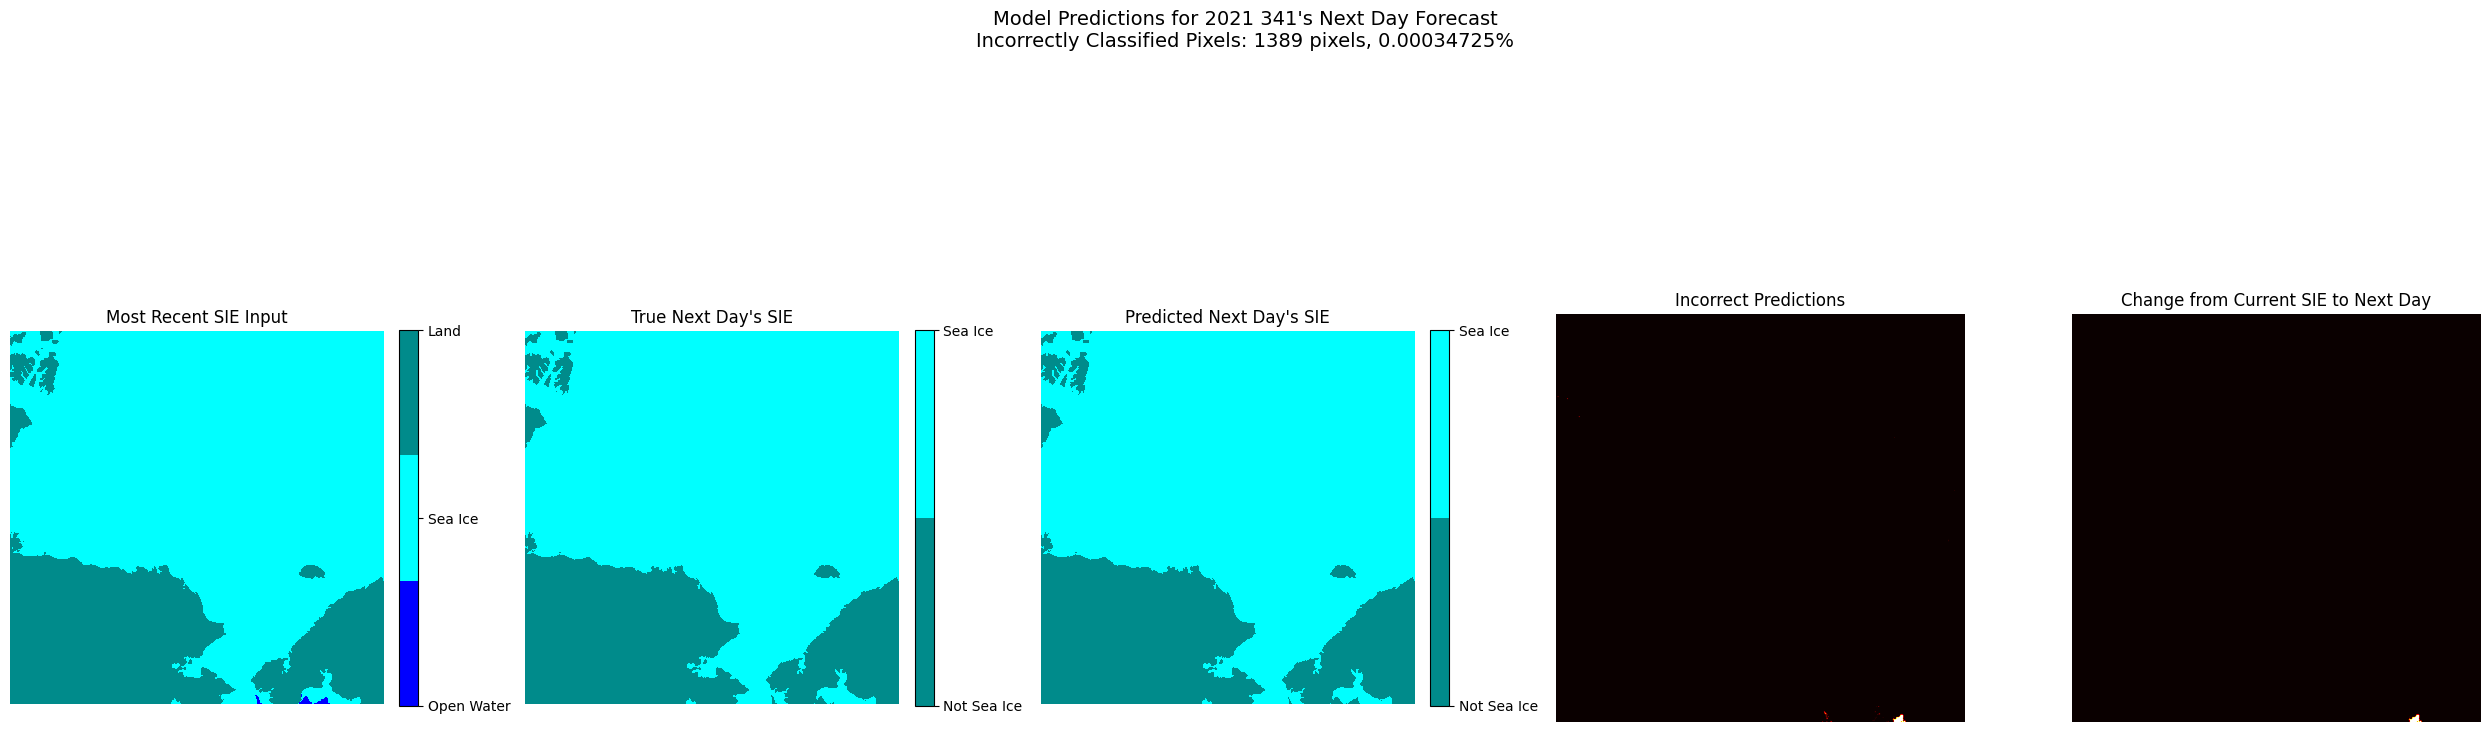

In [ ]:
# Get the batch data for test set
batch_index = 180
X_batch, y_true_batch = test_generator[batch_index]

# Generate predictions from the test data
y_pred_batch = model.predict(X_batch)
dates = test_generator.get_years_days_of_batch(batch_index)

# iterate over the batched predictions
for i in range(X_batch.shape[0]):
    plot_binary_model_predictions_with_errors(
        X_batch[i], y_true_batch[i], y_pred_batch[i], dates[i][0], dates[i][1]
    )

## Save model predictions for the test set

In [ ]:
# Create a path inside the checkpoint folder so it's clear what predictions are coming from what model
unet_model_pred_path = os.path.join(
    unet_checkpoint_dir, f"model_test_predictions_{len(test_files)}"
)
os.makedirs(unet_model_pred_path, exist_ok=True)

for batch_index in range(len(test_generator)):
    # Get the batch data for test set
    X_batch, y_true_batch = test_generator[batch_index]

    # Generate predictions from the test data
    y_pred_batch = model.predict(X_batch)
    dates = test_generator.get_years_days_of_batch(batch_index)

    # iterate over the batched predictions
    for i in range(X_batch.shape[0]):
        np.save(
            os.path.join(unet_model_pred_path, f"pred_{dates[i][0]}_{dates[i][1]}.npy"),
            y_pred_batch[i],
        )

1/1 [==============================] - 0s 122ms/step


In [ ]:
# Create a path inside the checkpoint folder so it's clear what predictions are coming from what model
unet_model_pred_path = os.path.join(
    unet_checkpoint_dir, f"model_validation_predictions_{len(test_files)}"
)
os.makedirs(unet_model_pred_path, exist_ok=True)
validation_generator = BinaryTargetGenerator(validation_files, batch_size=1, dim=dim)

for batch_index in tqdm.tqdm(range(len(validation_generator))):
    # Get the batch data for validation set
    X_batch, y_true_batch = validation_generator[batch_index]

    # Generate predictions from the validation data
    y_pred_batch = model.predict(X_batch)
    dates = validation_generator.get_years_days_of_batch(batch_index)

    # iterate over the batched predictions
    for i in range(X_batch.shape[0]):
        np.save(
            os.path.join(unet_model_pred_path, f"pred_{dates[i][0]}_{dates[i][1]}.npy"),
            y_pred_batch[i],
        )

  0%|          | 0/333 [00:00<?, ?it/s]

1/1 [==============================] - 0s 81ms/step


  0%|          | 1/333 [00:01<05:55,  1.07s/it]

1/1 [==============================] - 0s 91ms/step


  1%|          | 2/333 [00:02<06:01,  1.09s/it]

1/1 [==============================] - 0s 68ms/step


  1%|          | 3/333 [00:03<06:21,  1.16s/it]

1/1 [==============================] - 0s 65ms/step


  1%|          | 4/333 [00:04<05:22,  1.02it/s]

1/1 [==============================] - 0s 64ms/step


  2%|▏         | 5/333 [00:04<04:56,  1.10it/s]

1/1 [==============================] - 0s 65ms/step


  2%|▏         | 6/333 [00:05<04:40,  1.16it/s]

1/1 [==============================] - 0s 69ms/step


  2%|▏         | 7/333 [00:06<05:03,  1.07it/s]

1/1 [==============================] - 0s 72ms/step


  2%|▏         | 8/333 [00:07<04:39,  1.16it/s]

1/1 [==============================] - 0s 66ms/step


  3%|▎         | 9/333 [00:08<04:33,  1.18it/s]

1/1 [==============================] - 0s 66ms/step


  3%|▎         | 10/333 [00:08<04:21,  1.24it/s]

1/1 [==============================] - 0s 68ms/step


  3%|▎         | 11/333 [00:09<04:24,  1.22it/s]

1/1 [==============================] - 0s 69ms/step


  4%|▎         | 12/333 [00:10<04:48,  1.11it/s]

1/1 [==============================] - 0s 67ms/step


  4%|▍         | 13/333 [00:11<04:30,  1.18it/s]

1/1 [==============================] - 0s 64ms/step


  4%|▍         | 14/333 [00:12<04:24,  1.21it/s]

1/1 [==============================] - 0s 70ms/step


  5%|▍         | 15/333 [00:13<04:32,  1.17it/s]

1/1 [==============================] - 0s 102ms/step


  5%|▍         | 16/333 [00:14<04:58,  1.06it/s]

1/1 [==============================] - 0s 88ms/step


  5%|▌         | 17/333 [00:15<05:17,  1.01s/it]

1/1 [==============================] - 0s 111ms/step


  5%|▌         | 18/333 [00:16<05:33,  1.06s/it]

1/1 [==============================] - 0s 67ms/step


  6%|▌         | 19/333 [00:17<05:05,  1.03it/s]

1/1 [==============================] - 0s 72ms/step


  6%|▌         | 20/333 [00:18<04:46,  1.09it/s]

1/1 [==============================] - 0s 66ms/step


  6%|▋         | 21/333 [00:19<04:36,  1.13it/s]

1/1 [==============================] - 0s 77ms/step


  7%|▋         | 22/333 [00:19<04:21,  1.19it/s]

1/1 [==============================] - 0s 64ms/step


  7%|▋         | 23/333 [00:20<04:12,  1.23it/s]

1/1 [==============================] - 0s 65ms/step


  7%|▋         | 24/333 [00:21<04:09,  1.24it/s]

1/1 [==============================] - 0s 64ms/step


  8%|▊         | 25/333 [00:22<04:31,  1.13it/s]

1/1 [==============================] - 0s 63ms/step


  8%|▊         | 26/333 [00:23<04:24,  1.16it/s]

1/1 [==============================] - 0s 66ms/step


  8%|▊         | 27/333 [00:24<04:10,  1.22it/s]

1/1 [==============================] - 0s 66ms/step


  8%|▊         | 28/333 [00:24<04:01,  1.26it/s]

1/1 [==============================] - 0s 93ms/step


  9%|▊         | 29/333 [00:25<04:06,  1.23it/s]

1/1 [==============================] - 0s 84ms/step


  9%|▉         | 30/333 [00:26<04:09,  1.22it/s]

1/1 [==============================] - 0s 87ms/step


  9%|▉         | 31/333 [00:27<04:25,  1.14it/s]

1/1 [==============================] - 0s 98ms/step


 10%|▉         | 32/333 [00:28<04:57,  1.01it/s]

1/1 [==============================] - 0s 92ms/step


 10%|▉         | 33/333 [00:29<05:06,  1.02s/it]

1/1 [==============================] - 0s 104ms/step


 10%|█         | 34/333 [00:30<04:55,  1.01it/s]

1/1 [==============================] - 0s 69ms/step


 11%|█         | 35/333 [00:31<04:35,  1.08it/s]

1/1 [==============================] - 0s 81ms/step


 11%|█         | 36/333 [00:32<04:24,  1.12it/s]

1/1 [==============================] - 0s 66ms/step


 11%|█         | 37/333 [00:33<04:20,  1.14it/s]

1/1 [==============================] - 0s 69ms/step


 11%|█▏        | 38/333 [00:34<04:11,  1.17it/s]

1/1 [==============================] - 0s 67ms/step


 12%|█▏        | 39/333 [00:34<04:04,  1.20it/s]

1/1 [==============================] - 0s 62ms/step


 12%|█▏        | 40/333 [00:35<03:57,  1.24it/s]

1/1 [==============================] - 0s 62ms/step


 12%|█▏        | 41/333 [00:36<03:59,  1.22it/s]

1/1 [==============================] - 0s 62ms/step


 13%|█▎        | 42/333 [00:37<03:50,  1.26it/s]

1/1 [==============================] - 0s 65ms/step


 13%|█▎        | 43/333 [00:37<03:45,  1.28it/s]

1/1 [==============================] - 0s 66ms/step


 13%|█▎        | 44/333 [00:38<03:54,  1.23it/s]

1/1 [==============================] - 0s 73ms/step


 14%|█▎        | 45/333 [00:39<03:52,  1.24it/s]

1/1 [==============================] - 0s 68ms/step


 14%|█▍        | 46/333 [00:40<03:47,  1.26it/s]

1/1 [==============================] - 0s 86ms/step


 14%|█▍        | 47/333 [00:41<04:17,  1.11it/s]

1/1 [==============================] - 0s 82ms/step


 14%|█▍        | 48/333 [00:42<04:27,  1.07it/s]

1/1 [==============================] - 0s 102ms/step


 15%|█▍        | 49/333 [00:43<04:47,  1.01s/it]

1/1 [==============================] - 0s 65ms/step


 15%|█▌        | 50/333 [00:44<04:26,  1.06it/s]

1/1 [==============================] - 0s 63ms/step


 15%|█▌        | 51/333 [00:45<04:11,  1.12it/s]

1/1 [==============================] - 0s 69ms/step


 16%|█▌        | 52/333 [00:46<04:04,  1.15it/s]

1/1 [==============================] - 0s 72ms/step


 16%|█▌        | 53/333 [00:46<03:58,  1.18it/s]

1/1 [==============================] - 0s 65ms/step


 16%|█▌        | 54/333 [00:47<03:47,  1.22it/s]

1/1 [==============================] - 0s 88ms/step


 17%|█▋        | 55/333 [00:48<03:49,  1.21it/s]

1/1 [==============================] - 0s 69ms/step


 17%|█▋        | 56/333 [00:49<03:47,  1.22it/s]

1/1 [==============================] - 0s 66ms/step


 17%|█▋        | 57/333 [00:50<03:46,  1.22it/s]

1/1 [==============================] - 0s 83ms/step


 17%|█▋        | 58/333 [00:50<03:42,  1.24it/s]

1/1 [==============================] - 0s 65ms/step


 18%|█▊        | 59/333 [00:51<03:40,  1.24it/s]

1/1 [==============================] - 0s 65ms/step


 18%|█▊        | 60/333 [00:52<03:33,  1.28it/s]

1/1 [==============================] - 0s 67ms/step


 18%|█▊        | 61/333 [00:53<03:54,  1.16it/s]

1/1 [==============================] - 0s 89ms/step


 19%|█▊        | 62/333 [00:54<04:17,  1.05it/s]

1/1 [==============================] - 0s 97ms/step


 19%|█▉        | 63/333 [00:55<04:21,  1.03it/s]

1/1 [==============================] - 0s 88ms/step


 19%|█▉        | 64/333 [00:56<04:42,  1.05s/it]

1/1 [==============================] - 0s 64ms/step


 20%|█▉        | 65/333 [00:58<04:53,  1.09s/it]

1/1 [==============================] - 0s 62ms/step


 20%|█▉        | 66/333 [00:58<04:29,  1.01s/it]

1/1 [==============================] - 0s 64ms/step


 20%|██        | 67/333 [00:59<04:08,  1.07it/s]

1/1 [==============================] - 0s 70ms/step


 20%|██        | 68/333 [01:00<03:56,  1.12it/s]

1/1 [==============================] - 0s 68ms/step


 21%|██        | 69/333 [01:01<03:52,  1.14it/s]

1/1 [==============================] - 0s 70ms/step


 21%|██        | 70/333 [01:02<03:45,  1.16it/s]

1/1 [==============================] - 0s 73ms/step


 21%|██▏       | 71/333 [01:02<03:42,  1.18it/s]

1/1 [==============================] - 0s 67ms/step


 22%|██▏       | 72/333 [01:03<03:39,  1.19it/s]

1/1 [==============================] - 0s 90ms/step


 22%|██▏       | 73/333 [01:04<03:33,  1.22it/s]

1/1 [==============================] - 0s 62ms/step


 22%|██▏       | 74/333 [01:05<03:29,  1.24it/s]

1/1 [==============================] - 0s 63ms/step


 23%|██▎       | 75/333 [01:06<03:28,  1.24it/s]

1/1 [==============================] - 0s 63ms/step


 23%|██▎       | 76/333 [01:06<03:21,  1.27it/s]

1/1 [==============================] - 0s 130ms/step


 23%|██▎       | 77/333 [01:07<03:43,  1.14it/s]

1/1 [==============================] - 0s 82ms/step


 23%|██▎       | 78/333 [01:08<04:00,  1.06it/s]

1/1 [==============================] - 0s 104ms/step


 24%|██▎       | 79/333 [01:10<04:13,  1.00it/s]

1/1 [==============================] - 0s 67ms/step


 24%|██▍       | 80/333 [01:11<04:18,  1.02s/it]

1/1 [==============================] - 0s 64ms/step


 24%|██▍       | 81/333 [01:11<04:02,  1.04it/s]

1/1 [==============================] - 0s 67ms/step


 25%|██▍       | 82/333 [01:13<04:12,  1.01s/it]

1/1 [==============================] - 0s 66ms/step


 25%|██▍       | 83/333 [01:13<03:56,  1.06it/s]

1/1 [==============================] - 0s 64ms/step


 25%|██▌       | 84/333 [01:14<03:40,  1.13it/s]

1/1 [==============================] - 0s 63ms/step


 26%|██▌       | 85/333 [01:15<03:32,  1.16it/s]

1/1 [==============================] - 0s 66ms/step


 26%|██▌       | 86/333 [01:16<03:36,  1.14it/s]

1/1 [==============================] - 0s 68ms/step


 26%|██▌       | 87/333 [01:17<03:30,  1.17it/s]

1/1 [==============================] - 0s 70ms/step


 26%|██▋       | 88/333 [01:17<03:23,  1.21it/s]

1/1 [==============================] - 0s 84ms/step


 27%|██▋       | 89/333 [01:18<03:26,  1.18it/s]

1/1 [==============================] - 0s 77ms/step


 27%|██▋       | 90/333 [01:19<03:24,  1.19it/s]

1/1 [==============================] - 0s 69ms/step


 27%|██▋       | 91/333 [01:20<03:28,  1.16it/s]

1/1 [==============================] - 0s 116ms/step


 28%|██▊       | 92/333 [01:21<03:51,  1.04it/s]

1/1 [==============================] - 0s 135ms/step


 28%|██▊       | 93/333 [01:23<04:33,  1.14s/it]

1/1 [==============================] - 0s 172ms/step


 28%|██▊       | 94/333 [01:24<05:00,  1.26s/it]

1/1 [==============================] - 0s 126ms/step


 29%|██▊       | 95/333 [01:26<05:09,  1.30s/it]

1/1 [==============================] - 0s 68ms/step


 29%|██▉       | 96/333 [01:27<04:50,  1.22s/it]

1/1 [==============================] - 0s 66ms/step


 29%|██▉       | 97/333 [01:28<04:21,  1.11s/it]

1/1 [==============================] - 0s 67ms/step


 29%|██▉       | 98/333 [01:28<03:59,  1.02s/it]

1/1 [==============================] - 0s 87ms/step


 30%|██▉       | 99/333 [01:29<03:43,  1.05it/s]

1/1 [==============================] - 0s 63ms/step


 30%|███       | 100/333 [01:30<03:31,  1.10it/s]

1/1 [==============================] - 0s 62ms/step


 30%|███       | 101/333 [01:31<03:22,  1.15it/s]

1/1 [==============================] - 0s 71ms/step


 31%|███       | 102/333 [01:32<03:17,  1.17it/s]

1/1 [==============================] - 0s 64ms/step


 31%|███       | 103/333 [01:32<03:08,  1.22it/s]

1/1 [==============================] - 0s 66ms/step


 31%|███       | 104/333 [01:33<03:01,  1.26it/s]

1/1 [==============================] - 0s 86ms/step


 32%|███▏      | 105/333 [01:34<03:04,  1.23it/s]

1/1 [==============================] - 0s 67ms/step


 32%|███▏      | 106/333 [01:35<03:05,  1.22it/s]

1/1 [==============================] - 0s 88ms/step


 32%|███▏      | 107/333 [01:36<03:05,  1.22it/s]

1/1 [==============================] - 0s 90ms/step


 32%|███▏      | 108/333 [01:37<03:08,  1.19it/s]

1/1 [==============================] - 0s 92ms/step


 33%|███▎      | 109/333 [01:38<03:26,  1.09it/s]

1/1 [==============================] - 0s 94ms/step


 33%|███▎      | 110/333 [01:39<03:39,  1.01it/s]

1/1 [==============================] - 0s 81ms/step


 33%|███▎      | 111/333 [01:40<03:45,  1.01s/it]

1/1 [==============================] - 0s 67ms/step


 34%|███▎      | 112/333 [01:41<03:30,  1.05it/s]

1/1 [==============================] - 0s 68ms/step


 34%|███▍      | 113/333 [01:41<03:20,  1.10it/s]

1/1 [==============================] - 0s 68ms/step


 34%|███▍      | 114/333 [01:42<03:12,  1.14it/s]

1/1 [==============================] - 0s 76ms/step


 35%|███▍      | 115/333 [01:43<03:04,  1.18it/s]

1/1 [==============================] - 0s 66ms/step


 35%|███▍      | 116/333 [01:44<02:59,  1.21it/s]

1/1 [==============================] - 0s 65ms/step


 35%|███▌      | 117/333 [01:45<03:02,  1.18it/s]

1/1 [==============================] - 0s 77ms/step


 35%|███▌      | 118/333 [01:46<03:00,  1.19it/s]

1/1 [==============================] - 0s 64ms/step


 36%|███▌      | 119/333 [01:46<03:01,  1.18it/s]

1/1 [==============================] - 0s 78ms/step


 36%|███▌      | 120/333 [01:47<02:59,  1.18it/s]

1/1 [==============================] - 0s 65ms/step


 36%|███▋      | 121/333 [01:48<02:58,  1.19it/s]

1/1 [==============================] - 0s 67ms/step


 37%|███▋      | 122/333 [01:49<02:58,  1.18it/s]

1/1 [==============================] - 0s 68ms/step


 37%|███▋      | 123/333 [01:50<02:55,  1.20it/s]

1/1 [==============================] - 0s 98ms/step


 37%|███▋      | 124/333 [01:51<03:19,  1.05it/s]

1/1 [==============================] - 0s 93ms/step


 38%|███▊      | 125/333 [01:52<03:31,  1.02s/it]

1/1 [==============================] - 0s 107ms/step


 38%|███▊      | 126/333 [01:53<03:37,  1.05s/it]

1/1 [==============================] - 0s 65ms/step


 38%|███▊      | 127/333 [01:54<03:24,  1.01it/s]

1/1 [==============================] - 0s 71ms/step


 38%|███▊      | 128/333 [01:55<03:11,  1.07it/s]

1/1 [==============================] - 0s 80ms/step


 39%|███▊      | 129/333 [01:56<03:04,  1.10it/s]

1/1 [==============================] - 0s 67ms/step


 39%|███▉      | 130/333 [01:57<02:56,  1.15it/s]

1/1 [==============================] - 0s 65ms/step


 39%|███▉      | 131/333 [01:57<02:50,  1.19it/s]

1/1 [==============================] - 0s 92ms/step


 40%|███▉      | 132/333 [01:58<02:48,  1.19it/s]

1/1 [==============================] - 0s 67ms/step


 40%|███▉      | 133/333 [01:59<02:43,  1.22it/s]

1/1 [==============================] - 0s 63ms/step


 40%|████      | 134/333 [02:00<02:39,  1.24it/s]

1/1 [==============================] - 0s 88ms/step


 41%|████      | 135/333 [02:01<02:46,  1.19it/s]

1/1 [==============================] - 0s 64ms/step


 41%|████      | 136/333 [02:01<02:45,  1.19it/s]

1/1 [==============================] - 0s 69ms/step


 41%|████      | 137/333 [02:02<02:38,  1.24it/s]

1/1 [==============================] - 0s 68ms/step


 41%|████▏     | 138/333 [02:03<02:37,  1.23it/s]

1/1 [==============================] - 0s 91ms/step


 42%|████▏     | 139/333 [02:04<02:51,  1.13it/s]

1/1 [==============================] - 0s 100ms/step


 42%|████▏     | 140/333 [02:05<03:14,  1.01s/it]

1/1 [==============================] - 0s 85ms/step


 42%|████▏     | 141/333 [02:07<03:27,  1.08s/it]

1/1 [==============================] - 0s 66ms/step


 43%|████▎     | 142/333 [02:07<03:16,  1.03s/it]

1/1 [==============================] - 0s 78ms/step


 43%|████▎     | 143/333 [02:08<03:09,  1.00it/s]

1/1 [==============================] - 0s 70ms/step


 43%|████▎     | 144/333 [02:09<03:02,  1.04it/s]

1/1 [==============================] - 0s 65ms/step


 44%|████▎     | 145/333 [02:10<02:49,  1.11it/s]

1/1 [==============================] - 0s 66ms/step


 44%|████▍     | 146/333 [02:11<02:46,  1.12it/s]

1/1 [==============================] - 0s 65ms/step


 44%|████▍     | 147/333 [02:12<02:39,  1.17it/s]

1/1 [==============================] - 0s 68ms/step


 44%|████▍     | 148/333 [02:13<02:35,  1.19it/s]

1/1 [==============================] - 0s 67ms/step


 45%|████▍     | 149/333 [02:13<02:37,  1.17it/s]

1/1 [==============================] - 0s 65ms/step


 45%|████▌     | 150/333 [02:14<02:31,  1.21it/s]

1/1 [==============================] - 0s 63ms/step


 45%|████▌     | 151/333 [02:15<02:33,  1.19it/s]

1/1 [==============================] - 0s 64ms/step


 46%|████▌     | 152/333 [02:16<02:30,  1.20it/s]

1/1 [==============================] - 0s 65ms/step


 46%|████▌     | 153/333 [02:17<02:26,  1.22it/s]

1/1 [==============================] - 0s 138ms/step


 46%|████▌     | 154/333 [02:18<02:45,  1.08it/s]

1/1 [==============================] - 0s 97ms/step


 47%|████▋     | 155/333 [02:19<02:58,  1.01s/it]

1/1 [==============================] - 0s 93ms/step


 47%|████▋     | 156/333 [02:20<03:02,  1.03s/it]

1/1 [==============================] - 0s 66ms/step


 47%|████▋     | 157/333 [02:21<02:59,  1.02s/it]

1/1 [==============================] - 0s 72ms/step


 47%|████▋     | 158/333 [02:22<02:46,  1.05it/s]

1/1 [==============================] - 0s 62ms/step


 48%|████▊     | 159/333 [02:23<02:40,  1.09it/s]

1/1 [==============================] - 0s 80ms/step


 48%|████▊     | 160/333 [02:24<02:34,  1.12it/s]

1/1 [==============================] - 0s 64ms/step


 48%|████▊     | 161/333 [02:24<02:28,  1.16it/s]

1/1 [==============================] - 0s 64ms/step


 49%|████▊     | 162/333 [02:25<02:23,  1.20it/s]

1/1 [==============================] - 0s 71ms/step


 49%|████▉     | 163/333 [02:26<02:26,  1.16it/s]

1/1 [==============================] - 0s 67ms/step


 49%|████▉     | 164/333 [02:27<02:22,  1.19it/s]

1/1 [==============================] - 0s 65ms/step


 50%|████▉     | 165/333 [02:28<02:17,  1.22it/s]

1/1 [==============================] - 0s 66ms/step


 50%|████▉     | 166/333 [02:28<02:14,  1.24it/s]

1/1 [==============================] - 0s 66ms/step


 50%|█████     | 167/333 [02:29<02:17,  1.21it/s]

1/1 [==============================] - 0s 63ms/step


 50%|█████     | 168/333 [02:30<02:15,  1.22it/s]

1/1 [==============================] - 0s 84ms/step


 51%|█████     | 169/333 [02:31<02:25,  1.12it/s]

1/1 [==============================] - 0s 98ms/step


 51%|█████     | 170/333 [02:32<02:33,  1.06it/s]

1/1 [==============================] - 0s 95ms/step


 51%|█████▏    | 171/333 [02:33<02:44,  1.01s/it]

1/1 [==============================] - 0s 77ms/step


 52%|█████▏    | 172/333 [02:34<02:38,  1.02it/s]

1/1 [==============================] - 0s 68ms/step


 52%|█████▏    | 173/333 [02:35<02:27,  1.08it/s]

1/1 [==============================] - 0s 71ms/step


 52%|█████▏    | 174/333 [02:36<02:27,  1.08it/s]

1/1 [==============================] - 0s 69ms/step


 53%|█████▎    | 175/333 [02:37<02:22,  1.11it/s]

1/1 [==============================] - 0s 69ms/step


 53%|█████▎    | 176/333 [02:38<02:19,  1.12it/s]

1/1 [==============================] - 0s 65ms/step


 53%|█████▎    | 177/333 [02:38<02:15,  1.15it/s]

1/1 [==============================] - 0s 65ms/step


 53%|█████▎    | 178/333 [02:39<02:12,  1.17it/s]

1/1 [==============================] - 0s 64ms/step


 54%|█████▍    | 179/333 [02:40<02:08,  1.19it/s]

1/1 [==============================] - 0s 68ms/step


 54%|█████▍    | 180/333 [02:41<02:07,  1.20it/s]

1/1 [==============================] - 0s 66ms/step


 54%|█████▍    | 181/333 [02:42<02:07,  1.19it/s]

1/1 [==============================] - 0s 66ms/step


 55%|█████▍    | 182/333 [02:43<02:05,  1.21it/s]

1/1 [==============================] - 0s 67ms/step


 55%|█████▍    | 183/333 [02:43<02:02,  1.22it/s]

1/1 [==============================] - 0s 149ms/step


 55%|█████▌    | 184/333 [02:45<02:15,  1.10it/s]

1/1 [==============================] - 0s 120ms/step


 56%|█████▌    | 185/333 [02:46<02:28,  1.00s/it]

1/1 [==============================] - 0s 92ms/step


 56%|█████▌    | 186/333 [02:47<02:31,  1.03s/it]

1/1 [==============================] - 0s 66ms/step


 56%|█████▌    | 187/333 [02:48<02:27,  1.01s/it]

1/1 [==============================] - 0s 100ms/step


 56%|█████▋    | 188/333 [02:49<02:18,  1.05it/s]

1/1 [==============================] - 0s 69ms/step


 57%|█████▋    | 189/333 [02:49<02:13,  1.08it/s]

1/1 [==============================] - 0s 70ms/step


 57%|█████▋    | 190/333 [02:50<02:06,  1.13it/s]

1/1 [==============================] - 0s 72ms/step


 57%|█████▋    | 191/333 [02:51<02:03,  1.15it/s]

1/1 [==============================] - 0s 66ms/step


 58%|█████▊    | 192/333 [02:52<02:02,  1.15it/s]

1/1 [==============================] - 0s 65ms/step


 58%|█████▊    | 193/333 [02:53<01:58,  1.18it/s]

1/1 [==============================] - 0s 63ms/step


 58%|█████▊    | 194/333 [02:54<01:56,  1.19it/s]

1/1 [==============================] - 0s 64ms/step


 59%|█████▊    | 195/333 [02:54<01:51,  1.24it/s]

1/1 [==============================] - 0s 68ms/step


 59%|█████▉    | 196/333 [02:55<01:48,  1.27it/s]

1/1 [==============================] - 0s 69ms/step


 59%|█████▉    | 197/333 [02:56<01:52,  1.21it/s]

1/1 [==============================] - 0s 70ms/step


 59%|█████▉    | 198/333 [02:57<01:50,  1.22it/s]

1/1 [==============================] - 0s 104ms/step


 60%|█████▉    | 199/333 [02:58<01:59,  1.12it/s]

1/1 [==============================] - 0s 97ms/step


 60%|██████    | 200/333 [02:59<02:11,  1.01it/s]

1/1 [==============================] - 0s 100ms/step


 60%|██████    | 201/333 [03:00<02:11,  1.00it/s]

1/1 [==============================] - 0s 83ms/step


 61%|██████    | 202/333 [03:01<02:09,  1.01it/s]

1/1 [==============================] - 0s 64ms/step


 61%|██████    | 203/333 [03:02<02:01,  1.07it/s]

1/1 [==============================] - 0s 68ms/step


 61%|██████▏   | 204/333 [03:03<01:55,  1.12it/s]

1/1 [==============================] - 0s 74ms/step


 62%|██████▏   | 205/333 [03:03<01:51,  1.15it/s]

1/1 [==============================] - 0s 66ms/step


 62%|██████▏   | 206/333 [03:04<01:46,  1.20it/s]

1/1 [==============================] - 0s 68ms/step


 62%|██████▏   | 207/333 [03:05<01:41,  1.24it/s]

1/1 [==============================] - 0s 64ms/step


 62%|██████▏   | 208/333 [03:06<01:42,  1.22it/s]

1/1 [==============================] - 0s 78ms/step


 63%|██████▎   | 209/333 [03:07<01:43,  1.20it/s]

1/1 [==============================] - 0s 65ms/step


 63%|██████▎   | 210/333 [03:08<01:42,  1.20it/s]

1/1 [==============================] - 0s 70ms/step


 63%|██████▎   | 211/333 [03:08<01:39,  1.22it/s]

1/1 [==============================] - 0s 68ms/step


 64%|██████▎   | 212/333 [03:09<01:40,  1.20it/s]

1/1 [==============================] - 0s 66ms/step


 64%|██████▍   | 213/333 [03:10<01:38,  1.22it/s]

1/1 [==============================] - 0s 90ms/step


 64%|██████▍   | 214/333 [03:11<01:39,  1.20it/s]

1/1 [==============================] - 0s 102ms/step


 65%|██████▍   | 215/333 [03:12<01:47,  1.10it/s]

1/1 [==============================] - 0s 91ms/step


 65%|██████▍   | 216/333 [03:13<02:04,  1.06s/it]

1/1 [==============================] - 0s 63ms/step


 65%|██████▌   | 217/333 [03:14<02:02,  1.06s/it]

1/1 [==============================] - 0s 67ms/step


 65%|██████▌   | 218/333 [03:15<01:51,  1.03it/s]

1/1 [==============================] - 0s 64ms/step


 66%|██████▌   | 219/333 [03:16<01:45,  1.08it/s]

1/1 [==============================] - 0s 66ms/step


 66%|██████▌   | 220/333 [03:17<01:40,  1.13it/s]

1/1 [==============================] - 0s 80ms/step


 66%|██████▋   | 221/333 [03:18<01:36,  1.17it/s]

1/1 [==============================] - 0s 67ms/step


 67%|██████▋   | 222/333 [03:18<01:32,  1.20it/s]

1/1 [==============================] - 0s 66ms/step


 67%|██████▋   | 223/333 [03:19<01:29,  1.23it/s]

1/1 [==============================] - 0s 68ms/step


 67%|██████▋   | 224/333 [03:20<01:31,  1.20it/s]

1/1 [==============================] - 0s 64ms/step


 68%|██████▊   | 225/333 [03:21<01:31,  1.18it/s]

1/1 [==============================] - 0s 67ms/step


 68%|██████▊   | 226/333 [03:22<01:30,  1.18it/s]

1/1 [==============================] - 0s 64ms/step


 68%|██████▊   | 227/333 [03:22<01:26,  1.23it/s]

1/1 [==============================] - 0s 78ms/step


 68%|██████▊   | 228/333 [03:23<01:23,  1.26it/s]

1/1 [==============================] - 0s 70ms/step


 69%|██████▉   | 229/333 [03:24<01:25,  1.22it/s]

1/1 [==============================] - 0s 88ms/step


 69%|██████▉   | 230/333 [03:25<01:32,  1.11it/s]

1/1 [==============================] - 0s 90ms/step


 69%|██████▉   | 231/333 [03:26<01:43,  1.02s/it]

1/1 [==============================] - 0s 89ms/step


 70%|██████▉   | 232/333 [03:28<01:44,  1.03s/it]

1/1 [==============================] - 0s 64ms/step


 70%|██████▉   | 233/333 [03:28<01:37,  1.03it/s]

1/1 [==============================] - 0s 62ms/step


 70%|███████   | 234/333 [03:29<01:31,  1.08it/s]

1/1 [==============================] - 0s 62ms/step


 71%|███████   | 235/333 [03:30<01:26,  1.14it/s]

1/1 [==============================] - 0s 92ms/step


 71%|███████   | 236/333 [03:31<01:23,  1.16it/s]

1/1 [==============================] - 0s 70ms/step


 71%|███████   | 237/333 [03:32<01:20,  1.19it/s]

1/1 [==============================] - 0s 67ms/step


 71%|███████▏  | 238/333 [03:32<01:17,  1.22it/s]

1/1 [==============================] - 0s 65ms/step


 72%|███████▏  | 239/333 [03:33<01:17,  1.22it/s]

1/1 [==============================] - 0s 66ms/step


 72%|███████▏  | 240/333 [03:34<01:14,  1.25it/s]

1/1 [==============================] - 0s 80ms/step


 72%|███████▏  | 241/333 [03:35<01:16,  1.21it/s]

1/1 [==============================] - 0s 79ms/step


 73%|███████▎  | 242/333 [03:36<01:16,  1.19it/s]

1/1 [==============================] - 0s 63ms/step


 73%|███████▎  | 243/333 [03:37<01:17,  1.16it/s]

1/1 [==============================] - 0s 80ms/step


 73%|███████▎  | 244/333 [03:37<01:15,  1.18it/s]

1/1 [==============================] - 0s 90ms/step


 74%|███████▎  | 245/333 [03:38<01:21,  1.08it/s]

1/1 [==============================] - 0s 107ms/step


 74%|███████▍  | 246/333 [03:40<01:25,  1.01it/s]

1/1 [==============================] - 0s 87ms/step


 74%|███████▍  | 247/333 [03:41<01:31,  1.06s/it]

1/1 [==============================] - 0s 66ms/step


 74%|███████▍  | 248/333 [03:42<01:25,  1.01s/it]

1/1 [==============================] - 0s 90ms/step


 75%|███████▍  | 249/333 [03:43<01:21,  1.03it/s]

1/1 [==============================] - 0s 66ms/step


 75%|███████▌  | 250/333 [03:43<01:15,  1.10it/s]

1/1 [==============================] - 0s 62ms/step


 75%|███████▌  | 251/333 [03:44<01:11,  1.14it/s]

1/1 [==============================] - 0s 119ms/step


 76%|███████▌  | 252/333 [03:45<01:10,  1.15it/s]

1/1 [==============================] - 0s 64ms/step


 76%|███████▌  | 253/333 [03:46<01:07,  1.19it/s]

1/1 [==============================] - 0s 73ms/step


 76%|███████▋  | 254/333 [03:47<01:04,  1.23it/s]

1/1 [==============================] - 0s 69ms/step


 77%|███████▋  | 255/333 [03:47<01:01,  1.27it/s]

1/1 [==============================] - 0s 98ms/step


 77%|███████▋  | 256/333 [03:48<01:01,  1.25it/s]

1/1 [==============================] - 0s 67ms/step


 77%|███████▋  | 257/333 [03:49<01:01,  1.23it/s]

1/1 [==============================] - 0s 73ms/step


 77%|███████▋  | 258/333 [03:50<01:00,  1.24it/s]

1/1 [==============================] - 0s 62ms/step


 78%|███████▊  | 259/333 [03:51<01:01,  1.21it/s]

1/1 [==============================] - 0s 86ms/step


 78%|███████▊  | 260/333 [03:52<01:01,  1.18it/s]

1/1 [==============================] - 0s 118ms/step


 78%|███████▊  | 261/333 [03:53<01:04,  1.11it/s]

1/1 [==============================] - 0s 96ms/step


 79%|███████▊  | 262/333 [03:54<01:10,  1.01it/s]

1/1 [==============================] - 0s 84ms/step


 79%|███████▉  | 263/333 [03:55<01:10,  1.00s/it]

1/1 [==============================] - 0s 85ms/step


 79%|███████▉  | 264/333 [03:56<01:04,  1.07it/s]

1/1 [==============================] - 0s 67ms/step


 80%|███████▉  | 265/333 [03:56<01:03,  1.07it/s]

1/1 [==============================] - 0s 68ms/step


 80%|███████▉  | 266/333 [03:57<01:00,  1.11it/s]

1/1 [==============================] - 0s 66ms/step


 80%|████████  | 267/333 [03:58<00:56,  1.16it/s]

1/1 [==============================] - 0s 64ms/step


 80%|████████  | 268/333 [03:59<00:55,  1.17it/s]

1/1 [==============================] - 0s 65ms/step


 81%|████████  | 269/333 [04:00<00:54,  1.17it/s]

1/1 [==============================] - 0s 63ms/step


 81%|████████  | 270/333 [04:01<00:52,  1.20it/s]

1/1 [==============================] - 0s 86ms/step


 81%|████████▏ | 271/333 [04:01<00:50,  1.22it/s]

1/1 [==============================] - 0s 70ms/step


 82%|████████▏ | 272/333 [04:02<00:48,  1.25it/s]

1/1 [==============================] - 0s 64ms/step


 82%|████████▏ | 273/333 [04:03<00:49,  1.22it/s]

1/1 [==============================] - 0s 67ms/step


 82%|████████▏ | 274/333 [04:04<00:49,  1.20it/s]

1/1 [==============================] - 0s 67ms/step


 83%|████████▎ | 275/333 [04:05<00:46,  1.24it/s]

1/1 [==============================] - 0s 85ms/step


 83%|████████▎ | 276/333 [04:06<00:51,  1.11it/s]

1/1 [==============================] - 0s 91ms/step


 83%|████████▎ | 277/333 [04:07<00:52,  1.06it/s]

1/1 [==============================] - 0s 86ms/step


 83%|████████▎ | 278/333 [04:08<00:54,  1.01it/s]

1/1 [==============================] - 0s 72ms/step


 84%|████████▍ | 279/333 [04:09<00:54,  1.02s/it]

1/1 [==============================] - 0s 66ms/step


 84%|████████▍ | 280/333 [04:10<00:50,  1.04it/s]

1/1 [==============================] - 0s 76ms/step


 84%|████████▍ | 281/333 [04:10<00:46,  1.11it/s]

1/1 [==============================] - 0s 66ms/step


 85%|████████▍ | 282/333 [04:11<00:43,  1.16it/s]

1/1 [==============================] - 0s 64ms/step


 85%|████████▍ | 283/333 [04:12<00:42,  1.19it/s]

1/1 [==============================] - 0s 65ms/step


 85%|████████▌ | 284/333 [04:13<00:40,  1.22it/s]

1/1 [==============================] - 0s 66ms/step


 86%|████████▌ | 285/333 [04:14<00:40,  1.18it/s]

1/1 [==============================] - 0s 65ms/step


 86%|████████▌ | 286/333 [04:15<00:40,  1.16it/s]

1/1 [==============================] - 0s 67ms/step


 86%|████████▌ | 287/333 [04:15<00:38,  1.18it/s]

1/1 [==============================] - 0s 64ms/step


 86%|████████▋ | 288/333 [04:16<00:38,  1.17it/s]

1/1 [==============================] - 0s 76ms/step


 87%|████████▋ | 289/333 [04:17<00:36,  1.21it/s]

1/1 [==============================] - 0s 67ms/step


 87%|████████▋ | 290/333 [04:18<00:34,  1.23it/s]

1/1 [==============================] - 0s 109ms/step


 87%|████████▋ | 291/333 [04:19<00:35,  1.19it/s]

1/1 [==============================] - 0s 101ms/step


 88%|████████▊ | 292/333 [04:20<00:38,  1.07it/s]

1/1 [==============================] - 0s 96ms/step


 88%|████████▊ | 293/333 [04:21<00:40,  1.02s/it]

1/1 [==============================] - 0s 76ms/step


 88%|████████▊ | 294/333 [04:22<00:41,  1.06s/it]

1/1 [==============================] - 0s 67ms/step


 89%|████████▊ | 295/333 [04:23<00:36,  1.04it/s]

1/1 [==============================] - 0s 71ms/step


 89%|████████▉ | 296/333 [04:24<00:34,  1.09it/s]

1/1 [==============================] - 0s 69ms/step


 89%|████████▉ | 297/333 [04:25<00:32,  1.12it/s]

1/1 [==============================] - 0s 67ms/step


 89%|████████▉ | 298/333 [04:25<00:29,  1.17it/s]

1/1 [==============================] - 0s 95ms/step


 90%|████████▉ | 299/333 [04:27<00:31,  1.06it/s]

1/1 [==============================] - 0s 92ms/step


 90%|█████████ | 300/333 [04:28<00:33,  1.02s/it]

1/1 [==============================] - 0s 90ms/step


 90%|█████████ | 301/333 [04:29<00:33,  1.05s/it]

1/1 [==============================] - 0s 64ms/step


 91%|█████████ | 302/333 [04:30<00:30,  1.02it/s]

1/1 [==============================] - 0s 72ms/step


 91%|█████████ | 303/333 [04:30<00:27,  1.09it/s]

1/1 [==============================] - 0s 63ms/step


 91%|█████████▏| 304/333 [04:31<00:25,  1.12it/s]

1/1 [==============================] - 0s 64ms/step


 92%|█████████▏| 305/333 [04:32<00:23,  1.19it/s]

1/1 [==============================] - 0s 92ms/step


 92%|█████████▏| 306/333 [04:33<00:24,  1.10it/s]

1/1 [==============================] - 0s 107ms/step


 92%|█████████▏| 307/333 [04:34<00:26,  1.00s/it]

1/1 [==============================] - 0s 108ms/step


 92%|█████████▏| 308/333 [04:35<00:26,  1.04s/it]

1/1 [==============================] - 0s 67ms/step


 93%|█████████▎| 309/333 [04:36<00:23,  1.02it/s]

1/1 [==============================] - 0s 72ms/step


 93%|█████████▎| 310/333 [04:37<00:21,  1.06it/s]

1/1 [==============================] - 0s 68ms/step


 93%|█████████▎| 311/333 [04:38<00:20,  1.07it/s]

1/1 [==============================] - 0s 68ms/step


 94%|█████████▎| 312/333 [04:39<00:19,  1.09it/s]

1/1 [==============================] - 0s 63ms/step


 94%|█████████▍| 313/333 [04:40<00:17,  1.12it/s]

1/1 [==============================] - 0s 73ms/step


 94%|█████████▍| 314/333 [04:41<00:16,  1.18it/s]

1/1 [==============================] - 0s 69ms/step


 95%|█████████▍| 315/333 [04:41<00:15,  1.18it/s]

1/1 [==============================] - 0s 65ms/step


 95%|█████████▍| 316/333 [04:42<00:14,  1.19it/s]

1/1 [==============================] - 0s 67ms/step


 95%|█████████▌| 317/333 [04:43<00:14,  1.13it/s]

1/1 [==============================] - 0s 73ms/step


 95%|█████████▌| 318/333 [04:44<00:12,  1.16it/s]

1/1 [==============================] - 0s 64ms/step


 96%|█████████▌| 319/333 [04:45<00:11,  1.18it/s]

1/1 [==============================] - 0s 74ms/step


 96%|█████████▌| 320/333 [04:46<00:10,  1.19it/s]

1/1 [==============================] - 0s 85ms/step


 96%|█████████▋| 321/333 [04:47<00:11,  1.07it/s]

1/1 [==============================] - 0s 83ms/step


 97%|█████████▋| 322/333 [04:48<00:10,  1.03it/s]

1/1 [==============================] - 0s 90ms/step


 97%|█████████▋| 323/333 [04:49<00:10,  1.04s/it]

1/1 [==============================] - 0s 70ms/step


 97%|█████████▋| 324/333 [04:50<00:08,  1.03it/s]

1/1 [==============================] - 0s 94ms/step


 98%|█████████▊| 325/333 [04:51<00:07,  1.06it/s]

1/1 [==============================] - 0s 67ms/step


 98%|█████████▊| 326/333 [04:52<00:06,  1.05it/s]

1/1 [==============================] - 0s 63ms/step


 98%|█████████▊| 327/333 [04:52<00:05,  1.11it/s]

1/1 [==============================] - 0s 73ms/step


 98%|█████████▊| 328/333 [04:53<00:04,  1.13it/s]

1/1 [==============================] - 0s 65ms/step


 99%|█████████▉| 329/333 [04:54<00:03,  1.16it/s]

1/1 [==============================] - 0s 76ms/step


 99%|█████████▉| 330/333 [04:55<00:02,  1.16it/s]

1/1 [==============================] - 0s 67ms/step


 99%|█████████▉| 331/333 [04:56<00:01,  1.16it/s]

1/1 [==============================] - 0s 68ms/step


100%|█████████▉| 332/333 [04:57<00:00,  1.17it/s]

1/1 [==============================] - 0s 68ms/step


100%|██████████| 333/333 [04:58<00:00,  1.12it/s]


In [ ]:
# Create a path inside the checkpoint folder so it's clear what predictions are coming from what model
unet_model_pred_path = os.path.join(
    unet_checkpoint_dir, f"model_train_predictions_{len(test_files)}"
)
os.makedirs(unet_model_pred_path, exist_ok=True)
train_generator = BinaryTargetGenerator(train_files, batch_size=1, dim=dim)

for batch_index in range(len(train_generator)):
    # Get the batch data for train set
    X_batch, y_true_batch = train_generator[batch_index]

    # Generate predictions from the train data
    y_pred_batch = model.predict(X_batch)
    dates = train_generator.get_years_days_of_batch(batch_index)

    # iterate over the batched predictions
    for i in range(X_batch.shape[0]):
        np.save(
            os.path.join(unet_model_pred_path, f"pred_{dates[i][0]}_{dates[i][1]}.npy"),
            y_pred_batch[i],
        )

1/1 [==============================] - 0s 83ms/step


# Second Modeling Effort: Sobel

# Sobel UNET
## Training UNet Architecture for Edge Forecast Task

## Prototyping the sobel edge detection layer
In order to apply the edge detection as a layer in tensorflow, we need to wrap it so that it can be called.

In [ ]:
class SobelEdgeLayer(Layer):
    def __init__(self, threshold=1, **kwargs):
        super(SobelEdgeLayer, self).__init__(**kwargs)
        self.threshold = threshold

    def call(self, inputs):
        # Perform Sobel edge detection
        sobel_edges = tf.image.sobel_edges(inputs)

        # Extract edges for x and y directions and apply sigmoid activation
        activated = tf.square(sobel_edges[:, :, :, :, 0]) + tf.square(
            sobel_edges[:, :, :, :, 1]
        )
        return activated

    def compute_output_shape(self, input_shape):
        return input_shape


def simple_unet_with_sie_sobel(input_shape=(8000 * 2, 8000 * 2, 5)):
    "" """"""
    inputs = Input(input_shape)
    # Downsample
    c1 = Conv2D(16, (3, 3), activation="relu", padding="same")(inputs)
    p1 = MaxPooling2D((2, 2))(c1)
    c2 = Conv2D(32, (3, 3), activation="relu", padding="same")(p1)
    p2 = MaxPooling2D((2, 2))(c2)
    # Bottleneck
    b = Conv2D(64, (3, 3), activation="relu", padding="same")(p2)
    # Upsample
    u1 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding="same")(b)
    u1 = concatenate([u1, c2])
    u2 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding="same")(u1)
    u2 = concatenate([u2, c1])

    # Class prediction layer
    class_pred = Conv2D(1, (1, 1), activation="sigmoid")(u2)

    # Sobel edge layer (applied on class prediction)
    sobel_edges = SobelEdgeLayer()(class_pred)

    # Concatenate class prediction and Sobel edge detection results
    outputs = concatenate([class_pred, sobel_edges], axis=-1)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model


def simple_unet_with_sobel(input_shape=(8000 * 2, 8000 * 2, 5)):
    inputs = Input(input_shape)
    # Downsample
    c1 = Conv2D(16, (3, 3), activation="relu", padding="same")(inputs)
    p1 = MaxPooling2D((2, 2))(c1)
    c2 = Conv2D(32, (3, 3), activation="relu", padding="same")(p1)
    p2 = MaxPooling2D((2, 2))(c2)
    # Bottleneck
    b = Conv2D(64, (3, 3), activation="relu", padding="same")(p2)
    # Upsample
    u1 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding="same")(b)
    u1 = concatenate([u1, c2])
    u2 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding="same")(u1)
    u2 = concatenate([u2, c1])

    # Class prediction layer
    class_pred = Conv2D(1, (1, 1), activation="sigmoid")(u2)

    # Sobel edge layer (applied on class prediction)
    sobel_edges = SobelEdgeLayer()(class_pred)

    model = Model(inputs=[inputs], outputs=[sobel_edges])
    return model


def extended_unet_with_sie_sobel(input_shape=(2000, 2000, 4)):
    inputs = Input(input_shape)

    # Downsample
    c1 = Conv2D(16, (3, 3), activation="relu", padding="same")(inputs)
    p1 = MaxPooling2D((2, 2))(c1)
    c2 = Conv2D(32, (3, 3), activation="relu", padding="same")(p1)
    p2 = MaxPooling2D((2, 2))(c2)
    c3 = Conv2D(64, (3, 3), activation="relu", padding="same")(p2)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bottleneck
    b = Conv2D(128, (3, 3), activation="relu", padding="same")(p3)

    # Upsample
    u1 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(b)
    u1 = concatenate([u1, c3])
    u2 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding="same")(u1)
    u2 = concatenate([u2, c2])
    u3 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding="same")(u2)
    u3 = concatenate([u3, c1])

    # Class prediction layer
    class_pred = Conv2D(1, (1, 1), activation="sigmoid")(u3)

    # Sobel edge layer (applied on class prediction)
    sobel_edges = SobelEdgeLayer()(class_pred)

    # Concatenate class prediction and Sobel edge detection results
    outputs = concatenate([class_pred, sobel_edges], axis=-1)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [ ]:
def apply_sobel_edge_detection(image, threshold=1):
    """perform Sobel edge detection on an (optionally batched) image"""
    # Ensure image is a float32 tensor for TensorFlow operations
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    image = tf.expand_dims(image, axis=0)  # Add batch dimension

    # Perform Sobel edge detection
    sobel = tf.image.sobel_edges(image)
    sobel_x = sobel[..., 0]
    sobel_y = sobel[..., 1]

    edges_x = tf.square(sobel_x)
    edges_y = tf.square(sobel_y)
    edges = edges_x + edges_y

    return edges


class SobelGenerator(BinaryTargetGenerator):
    """
    Generator for Keras training to allow multiprocessing and training on batches with only the
    batch itself being loaded into memory.
    """

    def _data_generation(self, batch_data_ids):
        """Generates data containing batch_size samples"""
        X = np.empty((self.batch_size, *self.dim), dtype="float16")
        y = np.empty((self.batch_size, self.dim[0], self.dim[1], 2), dtype="float16")

        for i, (year, day) in enumerate(batch_data_ids):
            # Load a 5-day chunk as the input
            X[i,] = self.load_n_day_chunk(year, day, self.dim[2])

            # Load the next day as the target
            target_image = self.load_binary_y_for_day(year, day, self.dim[2])

            # Apply Sobel edge detection to the target and concatenate it to y
            sobel_edges = apply_sobel_edge_detection(target_image).numpy()
            batched_target_image = np.expand_dims(target_image, axis=0)
            sie_sobel_target = np.concatenate(
                [batched_target_image, sobel_edges], axis=-1
            )

            y[i] = sie_sobel_target

        return X, y

In [ ]:
def combined_sobel_sie_loss(y_true, y_pred, beta=0.5):
    """
    y_true and y_pred must be (batch_size, height, width, 2), with the last dimension being
    the binary ice/no ice SIE then the results of the sobel edge detection (not thresholded)

    Evaluates the binary cross entropy for the predicted and true SIE components of y_true and y_pred,
    evaluates MSE for the predicted sobel edge detection and the true sobel edge detection.
    """
    # Extract the class prediction part from y_true and y_pred
    class_true = y_true[..., 0]
    class_pred = y_pred[..., 0]

    # Extract the edge detection part from y_pred and y_true
    edge_pred = y_pred[..., 1]
    edge_true = y_true[..., 1]

    # Binary cross-entropy for the class predictions
    bce_loss = tf.keras.losses.binary_crossentropy(class_true, class_pred)

    # MSE for the edge detection part
    mse_loss = tf.keras.losses.mean_squared_error(edge_true, edge_pred)

    # Combine the losses with a weighting controlled by parameter beta.
    combined = (1 - beta) * bce_loss + beta * mse_loss
    return combined

### Loading/Compiling the Model and Training

In [ ]:
# Create the train/test generators for our Sobel+SIE data
sobel_train_generator = SobelGenerator(train_files, batch_size=batch_size, dim=dim)
sobel_test_generator = SobelGenerator(test_files, batch_size=test_batch_size, dim=dim)
sobel_validation_generator = SobelGenerator(
    validation_files, batch_size=batch_size, dim=dim
)

In [ ]:
datetime_string = datetime.datetime.now().strftime("%I:%M%p_%B_%d_%Y")

# Model checkpoint foldernames now generated by datetime (won't overwrite previous runs)
load = True
if not load:
    if IN_COLAB:
        sobel_checkpoint_dir = f"./model_checkpoints/jbacon/unet_sobel_with_sie_{datetime_string}_{WINDOW_SIZE}km_{dim[2]}dayhistory/"
    else:
        sobel_checkpoint_dir = os.path.join(
            "model_checkpoints",
            f"unet_sobel_with_sie_{datetime_string}_{WINDOW_SIZE}km_{dim[2]}dayhistory",
            "",
        )

    if not os.path.exists(sobel_checkpoint_dir):
        os.makedirs(sobel_checkpoint_dir)

else:  # If loading from file, set the checkpoint dir to be the one we're loading the model from.
    import pathlib

    first_ckpt = "./model_checkpoints/jbacon/unet_sobel_with_sie_07:45PM_March_30_2024_2000km/cp-0001.ckpt"
    third_ckpt = "./model_checkpoints/jbacon/unet_sobel_with_sie_10:10PM_March_30_2024_2000km/cp-0002.ckpt"

    # no lake mask, 3 day lookback, small model
    final_model = "./Saved Models/sobel_unet_with_2d_output_model.h5py"

    # lake mask, seven epochs, 3 day lookback, big model
    model_path = "./model_checkpoints/jbacon/unet_sobel_with_sie_02:49PM_April_22_2024_2000km_3dayhistory/cp-0007.ckpt"

    # lake mask, 9 epochs, 4 day lookback, small model
    small_model_path = "./model_checkpoints/jbacon/unet_sobel_with_sie_10:04PM_April_21_2024_2000km_4dayhistory/cp-0009.ckpt"

    sobel_checkpoint_dir = pathlib.Path(small_model_path).parent

In [ ]:
if load:
    sobel_model = tf.keras.models.load_model(
        third_ckpt,
        custom_objects={
            "SobelEdgeLayer": SobelEdgeLayer,
            "combined_sobel_sie_loss": combined_sobel_sie_loss,
        },
    )
else:  # Compile the model
    checkpoint_path = os.path.join(sobel_checkpoint_dir, "cp-{epoch:04d}.ckpt")

    checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_path,
        save_weights_only=False,
        monitor="loss",
        mode="min",
        save_best_only=True,
        verbose=1,
    )

    early_stopping_callback = EarlyStopping(
        monitor="loss", patience=10, verbose=1, mode="min"
    )

    sobel_model = simple_unet_with_sie_sobel(input_shape=dim)
    sobel_model.compile(
        optimizer="adam", loss=combined_sobel_sie_loss, metrics=["accuracy"]
    )

In [ ]:
# Train the Sobel + SIE model
history = sobel_model.fit(
    sobel_train_generator,
    epochs=20,
    callbacks=[checkpoint_callback, early_stopping_callback],
)

NameError: name 'checkpoint_callback' is not defined

## Take a look at the sobel model's results

1/1 [==============================] - 6s 6s/step


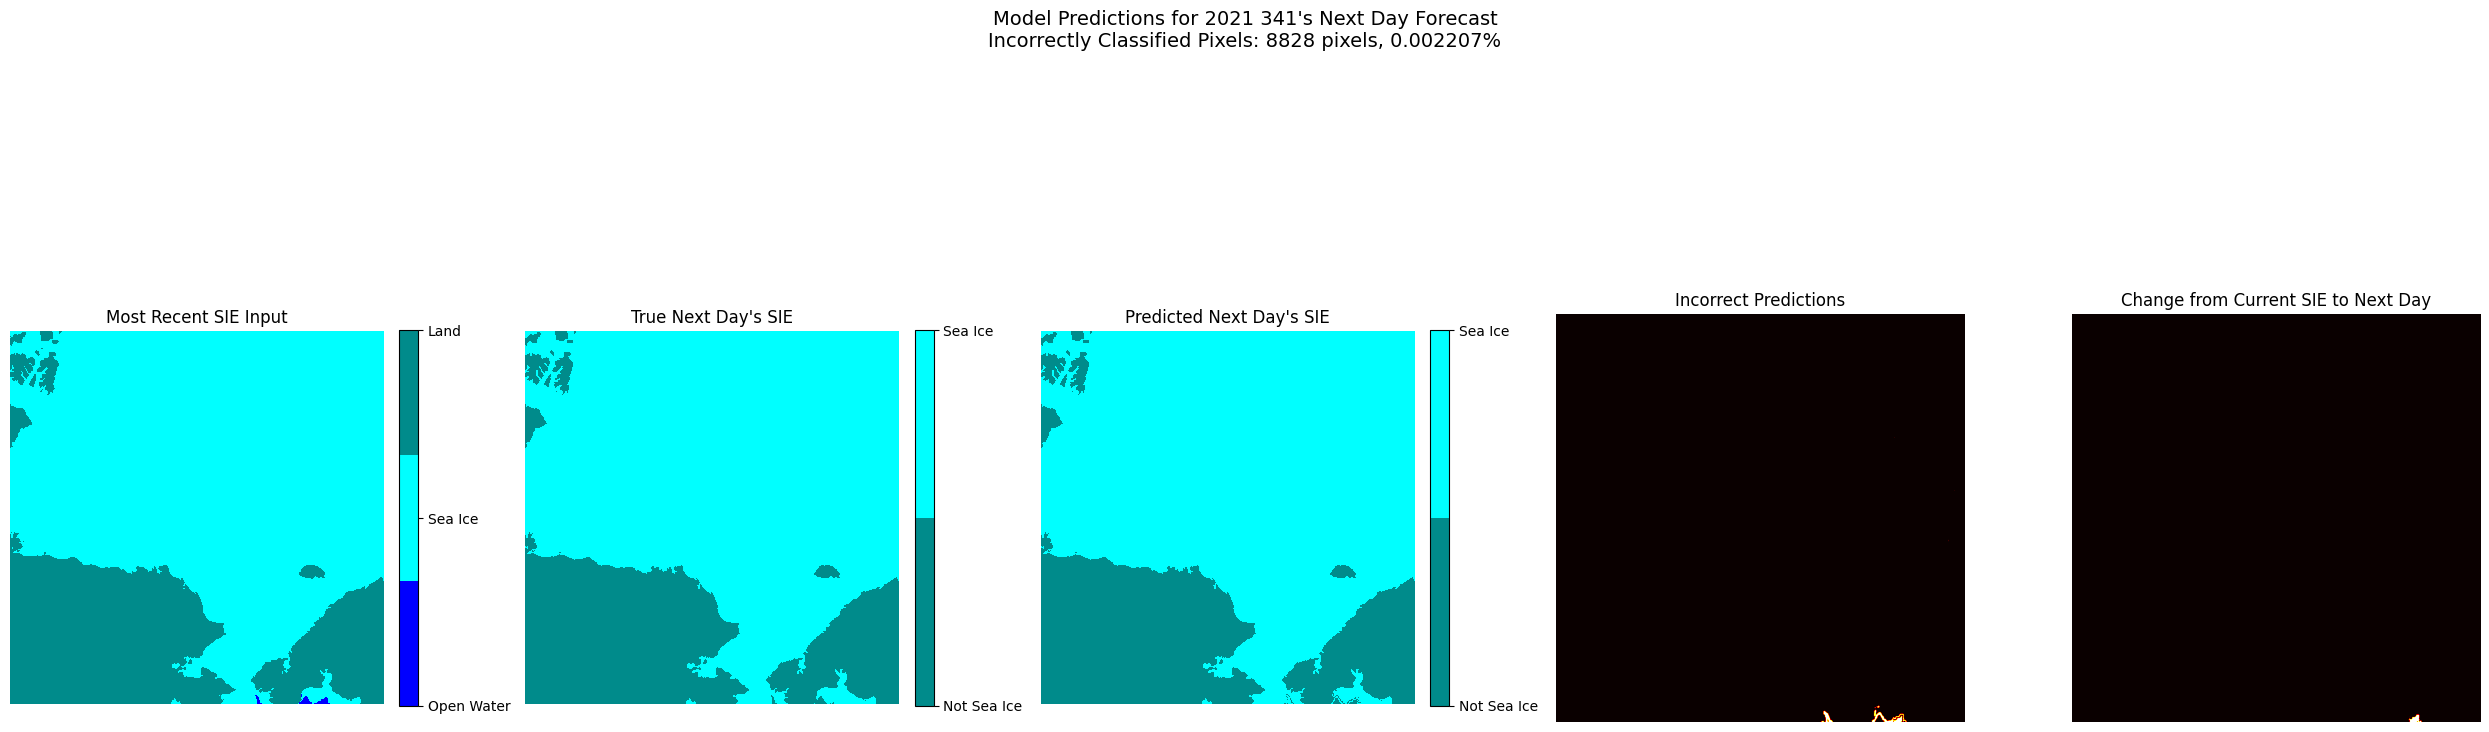

In [ ]:
# Get the batch data for test set
batch_index = 180
X_batch, y_true_batch = sobel_test_generator[batch_index]

# Generate predictions from the test data
y_pred_batch = sobel_model.predict(X_batch)
dates = sobel_test_generator.get_years_days_of_batch(batch_index)

# iterate over the batched predictions
for i in range(X_batch.shape[0]):
    plot_binary_model_predictions_with_errors(
        X_batch[i], y_true_batch[i], y_pred_batch[i], dates[i][0], dates[i][1]
    )

1/1 [==============================] - 0s 205ms/step


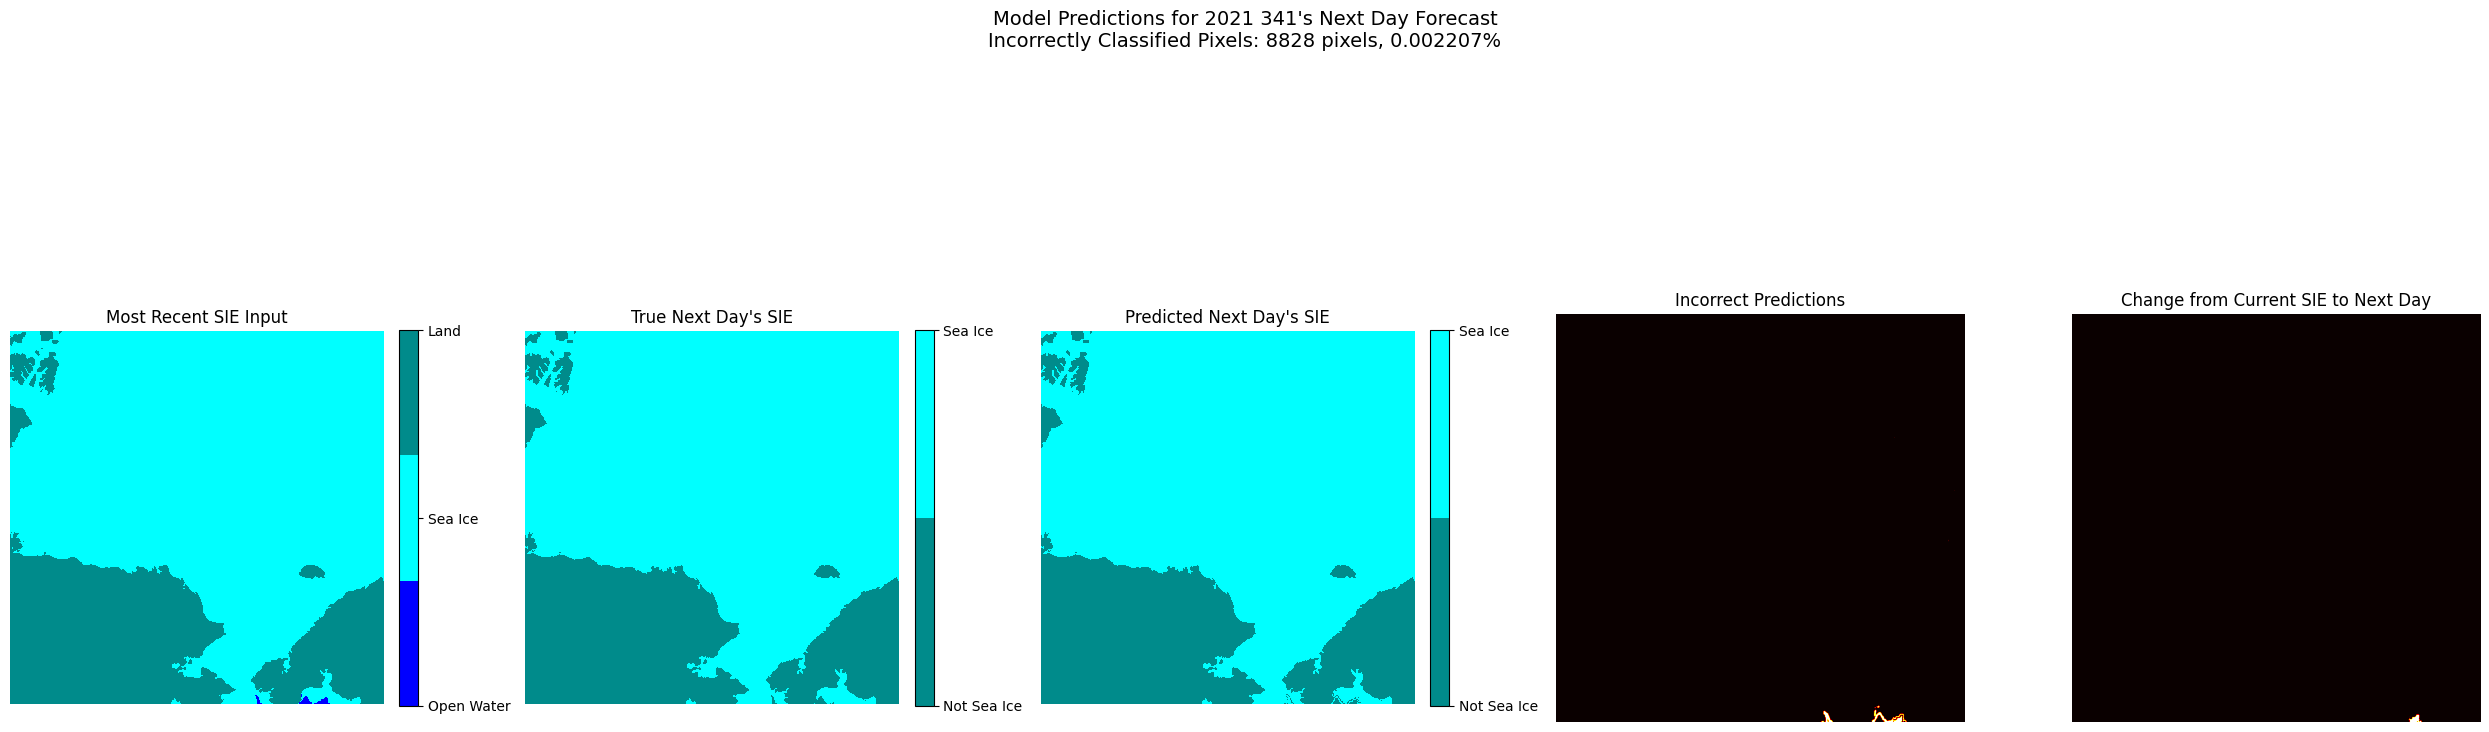

In [ ]:
# Get the batch data for test set
batch_index = 180
X_batch, y_true_batch = sobel_test_generator[batch_index]

# Generate predictions from the test data
y_pred_batch = sobel_model.predict(X_batch)
dates = sobel_test_generator.get_years_days_of_batch(batch_index)

# iterate over the batched predictions
for i in range(X_batch.shape[0]):
    plot_binary_model_predictions_with_errors(
        X_batch[i], y_true_batch[i], y_pred_batch[i], dates[i][0], dates[i][1]
    )

## Save model predictions for the test set

In [ ]:
model_pred_path = os.path.join(
    sobel_checkpoint_dir, f"model_test_predictions_{len(test_files)}"
)
os.makedirs(model_pred_path, exist_ok=True)

for batch_index in range(len(sobel_test_generator)):
    # Get the batch data for test set
    X_batch, y_true_batch = sobel_test_generator[batch_index]

    # Generate predictions from the test data
    y_pred_batch = sobel_model.predict(X_batch)
    dates = sobel_test_generator.get_years_days_of_batch(batch_index)

    # iterate over the batched predictions
    for i in range(X_batch.shape[0]):
        np.save(
            os.path.join(model_pred_path, f"pred_{dates[i][0]}_{dates[i][1]}.npy"),
            y_pred_batch[i],
        )

1/1 [==============================] - 0s 78ms/step


In [ ]:
model_pred_path = os.path.join(
    sobel_checkpoint_dir, f"model_validation_predictions_{len(validation_files)}"
)
os.makedirs(model_pred_path, exist_ok=True)

for batch_index in range(len(sobel_validation_generator)):
    # Get the batch data for validation set
    X_batch, y_true_batch = sobel_validation_generator[batch_index]

    # Generate predictions from the validation data
    y_pred_batch = sobel_model.predict(X_batch)
    dates = sobel_validation_generator.get_years_days_of_batch(batch_index)
    print(dates)
    # iterate over the batched predictions
    for i in range(X_batch.shape[0]):
        np.save(
            os.path.join(model_pred_path, f"pred_{dates[i][0]}_{dates[i][1]}.npy"),
            y_pred_batch[i],
        )

1/1 [==============================] - 6s 6s/step
[(2023, 100)]
1/1 [==============================] - 4s 4s/step
[(2023, 101)]
1/1 [==============================] - 6s 6s/step
[(2023, 102)]
1/1 [==============================] - 4s 4s/step
[(2023, 103)]
1/1 [==============================] - 7s 7s/step
[(2023, 104)]
1/1 [==============================] - 4s 4s/step
[(2023, 105)]
1/1 [==============================] - 4s 4s/step
[(2023, 106)]
1/1 [==============================] - 4s 4s/step
[(2023, 107)]
1/1 [==============================] - 4s 4s/step
[(2023, 108)]
1/1 [==============================] - 6s 6s/step
[(2023, 109)]
1/1 [==============================] - 4s 4s/step
[(2023, 110)]
1/1 [==============================] - 5s 5s/step
[(2023, 111)]
1/1 [==============================] - 4s 4s/step
[(2023, 112)]
1/1 [==============================] - 5s 5s/step
[(2023, 113)]
1/1 [==============================] - 4s 4s/step
[(2023, 114)]
1/1 [==============================] - 4

# Appendix

Sanity check that we have the right file associated with the right day/year.

157


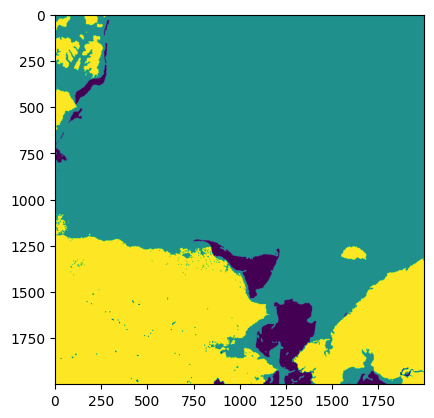

In [ ]:
day = 157
search = 5
target_ice = X_batch[0, :, :, -1].copy()
for i in range(day - search, day + search):
    potential_ice = trinarize_data(load_sie_data(year=2022, day=i))

    if np.allclose(potential_ice, target_ice):
        print(day)
        plt.imshow(potential_ice)
        plt.show()
        break

# Edge Detection

## Contour-based edge detection
This is maybe ok. It's closer to what IceNet does, but they also utilize masking out all boundaries/edges that aren't sea-ice to open ocean.

It'll be very hard to line up which boundary should get compared to which. We get a collection of contiguous lines from this contour based approach, but when we get a different collection of lines/edges from the true target, how do we compare them? How do you know that you're comparing the contour around one island to that same island in the second image?

Additionally, I don't think this is differentiable, which is fine for evaluation, but it would be great to embed this into our model if possible to force it to learn how to forecast edges better.

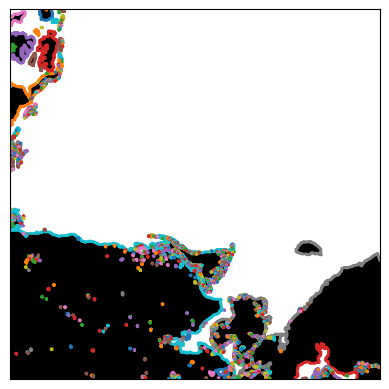

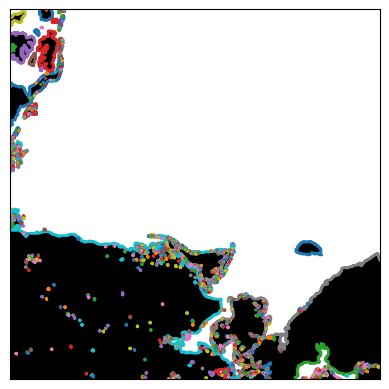

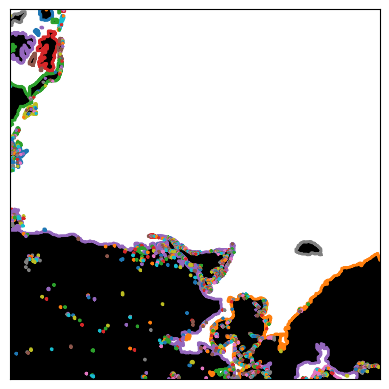

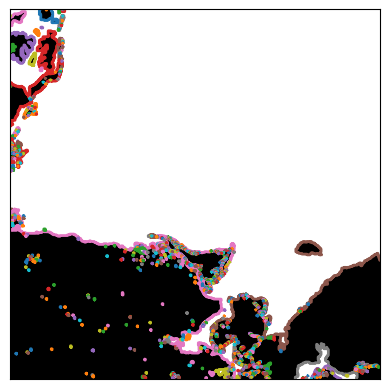

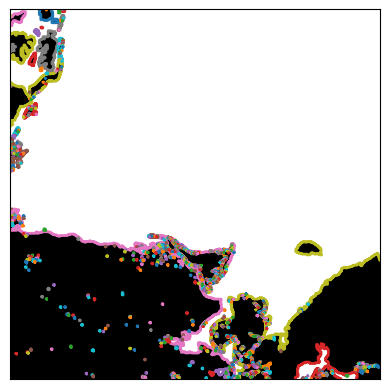

In [ ]:
for i in [0.1, 0.5, 0.6, 0.7, 0.8]:
    contours = skimage.measure.find_contours(y_pred_batch[0, :, :, 0], i)

    # Display the image and plot all contours found
    fig, ax = plt.subplots()
    ax.imshow(y_pred_batch[0, :, :, 0], cmap=plt.cm.gray)

    for contour in contours:
        ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

    ax.axis("image")
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()

### Quick look at IceNet's work
```
def arr_to_ice_edge_arr(arr, thresh, land_mask, region_mask):

    '''
    Credit IceNet https://github.com/tom-andersson/icenet-paper/blob/79ab77c452088d805514d0ba2f3ad86581945954/icenet/utils.py#L1808
    Compute a boolean mask with True over ice edge contour grid cells using
    matplotlib.pyplot.contour and an input threshold to define the ice edge
    (e.g. 0.15 for the 15% SIC ice edge or 0.5 for SIP forecasts). The contour
    along the coastline is removed using the region mask.
    '''

    X, Y = np.meshgrid(np.arange(arr.shape[0]), np.arange(arr.shape[1]))
    X = X.T
    Y = Y.T

    cs = plt.contour(X, Y, arr, [thresh], alpha=0)  # Do not plot on any axes
    x = []
    y = []
    for p in cs.collections[0].get_paths():
        x_i, y_i = p.vertices.T
        x.extend(np.round(x_i))
        y.extend(np.round(y_i))
    x = np.array(x, int)
    y = np.array(y, int)
    ice_edge_arr = np.zeros(arr.shape, dtype=bool)
    ice_edge_arr[x, y] = True
    # Mask out ice edge contour that hugs the coastline
    ice_edge_arr[land_mask] = False
    ice_edge_arr[region_mask == 13] = False

    return ice_edge_arr

```

## Filter based Edge Detection: Sobel prototype
This still really needs a lake and land mask, but calculating the absolute value of the tensorflow sobel edge detection, thresholding, and combining the x, y sobel filter directions yields a very nice looking edge.

Because we don't have a land & lake mask, this is mostly picking up the edges of the landmasses. We likely want to just evaluate the sea-ice to open ocean boundary and evaluate our ice-edge metrics against that.

Really nice that this is a differentiable system, so we can embed this into our model with a little work and compute the model outputs the current SIE predictions plus the result of the sobel edge detection.

By finding a good threshold for this, we can likely just use the same loss function (binary cross entropy). This would mean computing the sobel edge detection for the y_target as well. It's still not utilizing any of the ice-edge metrics that we really care about in the loss function, but is a step towards informing the model how important ice edges are and penalizing it for incorrect edge forecasts.

In [ ]:
truth = tf.convert_to_tensor(X_batch.T)
sobel = tf.image.sobel_edges(truth)
sobel_y = np.asarray(sobel[:, :, :, 0, 0])  # sobel in y-direction
sobel_x = np.asarray(sobel[:, :, :, 0, 1])  # sobel in x-direction
ideal_sobel = (np.abs(sobel_y[0]) > 1) + (np.abs(sobel_x[0]) > 1)

In [ ]:
# Perform Sobel edge detection
sobel_edges = tf.image.sobel_edges(truth)
activated = Activation("sigmoid")(
    tf.square(sobel_edges[:, :, :, :, 0]) + tf.square(sobel_edges[:, :, :, :, 1])
)

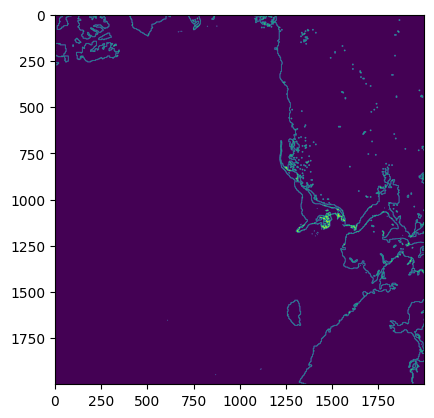

In [ ]:
plt.imshow((activated[0, :, :, 0]))

In [ ]:
np.unique(sobel_x)

array([-8., -7., -6., -5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,
        5.,  6.,  7.,  8.], dtype=float16)

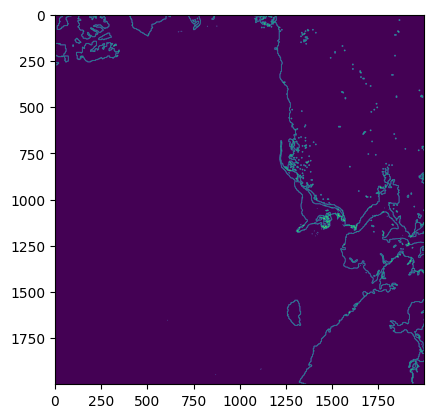

In [ ]:
plt.imshow((np.abs(sobel_y[0]) > 1) + (np.abs(sobel_x[0]) > 1))